In [52]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
import sklearn
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from bayes_opt import BayesianOptimization

from skopt import BayesSearchCV
from datetime import datetime
from boruta import BorutaPy




warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 300

FEATS_EXCLUDED = ['target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0', 'hist_purchase_date_ptp', 'new_purchase_date_ptp'
                 ]
from sklearn.metrics import fbeta_score, make_scorer

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def ratio_one(x):
    return len(x[x==1.0])/len(x)

def ratio_zero(x):
    return len(x[x==0.0])/len(x)

def ratio_minusone(x):
    return len(x[x==-1.0])/len(x)

def Mode(x):
    # if the most frequent & 2nd most frequent one have the same frequencies, take the bigger one
    counts = Counter(x)
    tup = sorted(counts.items(), key=lambda kv: kv[1])
    return tup[-1][0]

FEATS_EXCLUDED = ['target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0', 'hist_purchase_date_ptp', 'new_purchase_date_ptp'
                 ]
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def drop_col(df, col=['purchase_date_month']):
    df.drop(col, axis=1, inplace=True)
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def filter_by_nan(df, thres=0.9):
    droplist = []
    for col in df.columns:
        if df[col].isna().sum() / len(df) >= thres:
            droplist.append(col)
    df.drop(droplist, axis=1, inplace=True)

In [48]:
len(df)

325540

In [66]:
train_df = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv', index_col=['card_id'])
test_df = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv', index_col=['card_id'])
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
test_df['target'] = np.nan
df = train_df.append(test_df)
del train_df, test_df
gc.collect()

49

In [67]:
df['first_active_month'] = pd.to_datetime(df['first_active_month'])
df['first_active_year'] = df['first_active_month'].dt.year
df['first_active_quarter'] = df['first_active_month'].dt.quarter
df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
df['first_active_month'] = df['first_active_month'].dt.month



In [68]:
hist_df = pd.read_hdf('Elo_fe.h5', 'hist_df_fillna')
new_merchant_df = pd.read_hdf('Elo_fe.h5', 'new_merchant_df_fillna')


In [25]:
#hist_df['has_last_month_transaction'].value_counts()

 1.0    18990547
-1.0    10218132
 0.0           5
Name: has_last_month_transaction, dtype: int64

In [21]:
pd.DataFrame(hist_df.dtypes)

,0
authorized_flag,int64
card_id,object
city_id,int64
category_1,int64
merchant_category_id,int64
merchant_id,object
purchase_amount,float64
state_id,int64
subsector_id,int64
merchant_group_id,float64


In [82]:
aggs = {}
aggs['authorized_flag'] = ['count', 'mean']

for k in ['category_1', 'category_2_1.0', 'category_2_2.0', 'category_2_3.0', 'category_2_4.0', 'category_2_5.0', 'category_2_nan', 'category_3_A', 'category_3_B', 'category_3_C', 'category_4']:
    aggs[k] = ['mean']

for k in ['most_recent_sales_range', 'most_recent_purchases_range', 'avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12','avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12',
          'numerical_1', 'numerical_2', 'numerical_ratio', 'price']:
    aggs[k] = ['mean']
    
for k in ['has_last_month_transaction', 'has_last3_months_revenue']:
    aggs[k] = [ratio_one, ratio_zero, ratio_minusone]

for k in ['purchase_date_year', 'purchase_date_month', 'purchase_date_day', 'purchase_date_dayofweek', 'purchase_date_hour', 'purchase_date_weekofyear', 'purchase_date_weekday', 'purchase_date_quarter']:
    aggs[k] = ['mean', Mode]

for k in ['month_diff_orig', 'month_lag_orig']:
    aggs[k] = ['mean', 'median', Mode]

aggs['installments_orig'] = ['nunique', Mode]
aggs['purchase_amount'] = ['sum', 'mean', 'median','std', 'skew']


In [83]:
%%time
hist_agg = hist_df.groupby('card_id').agg(aggs)

CPU times: user 15min 10s, sys: 15.9 s, total: 15min 26s
Wall time: 15min 27s


In [84]:
hist_agg.shape

(325540, 60)

In [85]:
%%time
del aggs['authorized_flag']
new_agg = new_merchant_df.groupby('card_id').agg(aggs)

CPU times: user 9min 41s, sys: 2.53 s, total: 9min 43s
Wall time: 9min 44s


In [86]:
new_agg.shape

(290001, 58)

In [232]:
hist_add = pd.read_hdf('Elo_fe.h5', 'hist_add')
new_add = pd.read_hdf('Elo_fe.h5', 'new_add')

In [234]:
hist_add.drop(['hist_Max', 'hist_Min'], axis=1, inplace=True)
new_add.drop(['new_Max', 'new_Min'], axis=1, inplace=True)
hist_add = hist_add.set_index('card_id')
new_add = new_add.set_index('card_id')

In [87]:
hist_add.head()

,hist_Frequency,hist_Monitary,hist_Recency,hist_Time,hist_historic_CLV,hist_AOV,hist_Predictive_CLV
card_id,,,,,,,
C_ID_00007093c1,149,-76.845041,337.0,377.0,-11449.911042,-0.515739,5.035199e+06
C_ID_0001238066,123,-72.447201,336.0,151.0,-8911.005737,-0.589002,2.164982e+06
C_ID_0001506ef0,66,-34.601879,347.0,398.0,-2283.724033,-0.524271,2.505348e+06
C_ID_0001793786,216,-36.786013,455.0,283.0,-7945.778765,-0.170306,8.066953e+05
C_ID_000183fdda,144,-68.837938,338.0,202.0,-9912.663098,-0.478041,2.246784e+06


In [235]:
new_add.head()

,new_Frequency,new_Monitary,new_Recency,new_Time,new_historic_CLV,new_AOV,new_Predictive_CLV
card_id,,,,,,,
C_ID_00007093c1,2,-1.328524,295.0,6.0,-2.657048,-0.664262,1562.003682
C_ID_0001238066,26,-14.850055,274.0,60.0,-386.101441,-0.571156,139439.114216
C_ID_0001506ef0,2,-1.447354,314.0,5.0,-2.894707,-0.723677,1644.443514
C_ID_0001793786,31,-0.229620,394.0,46.0,-7.118224,-0.007407,30.825650
C_ID_000183fdda,11,-6.590778,274.0,59.0,-72.498562,-0.599162,63838.592150


In [62]:
df.shape

(325540, 9)

In [69]:
df = df.join(hist_add, how='left')
df = df.join(new_add, how='left')


In [88]:
df.shape

(325540, 23)

In [71]:
df.head()

,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active_year,first_active_quarter,elapsed_time,hist_Frequency,hist_Monitary,hist_Recency,hist_Time,hist_historic_CLV,hist_AOV,hist_Predictive_CLV,new_Frequency,new_Monitary,new_Recency,new_Time,new_historic_CLV,new_AOV,new_Predictive_CLV
card_id,,,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,5,2,1,6.0,0.0,-0.820283,2017.0,2.0,612.0,260,-165.968739,339.0,242.0,-43151.872249,-0.638341,8.691491e+06,23.0,-13.244202,276.0,54.0,-304.616651,-0.575835,113664.962132
C_ID_3d0044924f,4,1,0,1.0,0.0,0.392913,2017.0,1.0,763.0,350,-210.006336,363.0,390.0,-73502.217716,-0.600018,1.783890e+07,6.0,-4.355735,306.0,56.0,-26.134410,-0.725956,54185.251880
C_ID_d639edf6cd,2,2,0,8.0,0.0,0.688056,2016.0,3.0,916.0,43,-29.167391,336.0,412.0,-1254.197817,-0.678311,2.738818e+06,1.0,-0.700326,276.0,0.0,-0.700326,-0.700326,0.000000
C_ID_186d6a6901,4,3,0,9.0,0.0,0.142495,2017.0,3.0,520.0,77,-49.491364,336.0,154.0,-3810.835055,-0.642745,1.645994e+06,7.0,-4.654372,287.0,41.0,-32.580603,-0.664910,36415.801228
C_ID_cdbd2c0db2,1,3,0,11.0,0.0,-0.159749,2017.0,4.0,459.0,133,-48.687656,335.0,108.0,-6475.458291,-0.366073,6.448440e+05,36.0,-19.926237,276.0,57.0,-717.344516,-0.553507,173512.992631


In [89]:
hist_agg.columns = ['_'.join(col).strip() for col in hist_agg.columns.values]
new_agg.columns = ['_'.join(col).strip() for col in new_agg.columns.values]


In [90]:
hist_agg.head()

,authorized_flag_count,authorized_flag_mean,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_2_nan_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,category_4_mean,most_recent_sales_range_mean,most_recent_purchases_range_mean,avg_sales_lag3_mean,avg_sales_lag6_mean,avg_sales_lag12_mean,avg_purchases_lag3_mean,avg_purchases_lag6_mean,avg_purchases_lag12_mean,numerical_1_mean,numerical_2_mean,numerical_ratio_mean,price_mean,has_last_month_transaction_ratio_one,has_last_month_transaction_ratio_zero,has_last_month_transaction_ratio_minusone,has_last3_months_revenue_ratio_one,has_last3_months_revenue_ratio_zero,has_last3_months_revenue_ratio_minusone,purchase_date_year_mean,purchase_date_year_Mode,purchase_date_month_mean,purchase_date_month_Mode,purchase_date_day_mean,purchase_date_day_Mode,purchase_date_dayofweek_mean,purchase_date_dayofweek_Mode,purchase_date_hour_mean,purchase_date_hour_Mode,purchase_date_weekofyear_mean,purchase_date_weekofyear_Mode,purchase_date_weekday_mean,purchase_date_weekday_Mode,purchase_date_quarter_mean,purchase_date_quarter_Mode,month_diff_orig_mean,month_diff_orig_median,month_diff_orig_Mode,month_lag_orig_mean,month_lag_orig_median,month_lag_orig_Mode,installments_orig_nunique,installments_orig_Mode,purchase_amount_sum,purchase_amount_mean,purchase_amount_median,purchase_amount_std,purchase_amount_skew
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,149,0.765101,0.187919,0.000000,0.000000,0.805369,0.0,0.006711,0.187919,0.000000,0.838926,0.161074,-0.409396,0.369128,0.348993,1.006107,1.011342,1.018658,1.021769,1.024085,1.034652,0.057890,0.047842,0.110781,-0.932886,0.295302,0.0,0.704698,0.295302,0.0,0.704698,2017.147651,2017,8.147651,6,13.248322,8,2.241611,0,14.416107,16,25.550336,16,0.167785,0,1.476510,1,11.348993,11.0,11,-5.852349,-6.0,-8,5,1,-76.845041,-0.515739,-0.587627,0.298141,3.966544
C_ID_0001238066,123,0.975610,0.016260,0.772358,0.000000,0.000000,0.0,0.162602,0.065041,0.000000,0.715447,0.260163,-0.065041,1.601626,1.780488,1.027805,1.045935,1.074228,1.046337,1.067304,1.091462,8.861922,8.788084,0.730504,-0.967480,0.804878,0.0,0.195122,0.804878,0.0,0.195122,2017.406504,2017,12.186992,12,16.138211,23,3.504065,5,14.739837,19,29.967480,51,0.422764,0,1.764228,3,11.178862,11.0,11,-1.813008,-2.0,-2,9,1,-72.447201,-0.589002,-0.648184,0.190235,4.057432
C_ID_0001506ef0,66,0.939394,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,0.000000,0.984848,0.015152,0.000000,0.636364,2.196970,2.257576,1.045303,1.062879,1.075000,1.063670,1.084259,1.105739,0.993893,0.857488,-0.838177,-0.757576,0.818182,0.0,0.181818,0.818182,0.0,0.181818,2017.196970,2017,9.166667,12,12.000000,6,3.575758,5,12.606061,12,27.090909,49,0.484848,0,1.515152,0,11.272727,11.0,11,-4.833333,-3.0,-2,2,0,-34.601879,-0.524271,-0.703707,0.472284,2.692444
C_ID_0001793786,216,0.875000,0.009259,0.050926,0.351852,0.069444,0.0,0.000000,0.527778,0.976852,0.023148,0.000000,-0.708333,-0.356481,-0.356481,1.092963,1.161620,1.204861,1.073406,1.124130,1.161002,0.044717,0.039484,0.091760,-0.564815,0.231481,0.0,0.768519,0.231481,0.0,0.768519,2017.000000,2017,6.671296,9,16.115741,14,2.694444,1,15.606481,13,27.134259,37,0.171296,0,1.541667,2,15.212963,15.0,15,-3.328704,-3.0,-1,2,0,-36.786013,-0.170306,-0.487911,0.836046,3.001742
C_ID_000183fdda,144,0.951389,0.027778,0.048611,0.006944,0.909722,0.0,0.006944,0.027778,0.000000,0.715278,0.256944,0.611111,1.597222,1.465278,1.039375,1.132431,1.091667,1.044542,1.068437,1.053525,0.150143,0.104700,0.122094,-0.868055,0.805556,0.0,0.194444,0.805556,0.0,0.194444,2017.388889,2017,11.548611,13,14.034722,8,2.937500,3,16.465278,22,27.881944,2,0.229167,0,1.638889,3,11.208333,11.0,11,-2.451389,-2.0,-1,8,1,-68.837938,-0.478041,-0.661294,0.524948,3.840939


In [91]:
hist_agg.to_hdf('Elo_fe.h5', 'hist_agg')
new_agg.to_hdf('Elo_fe.h5', 'new_agg')

In [93]:
hist_agg = hist_agg.add_prefix('hist_')
new_agg = new_agg.add_prefix('new_')


In [94]:
df = df.join(hist_agg, how='left')
df = df.join(new_agg, how='left')
df.shape

(325540, 141)

In [95]:
df.head()

,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active_year,first_active_quarter,elapsed_time,hist_Frequency,hist_Monitary,hist_Recency,hist_Time,hist_historic_CLV,hist_AOV,hist_Predictive_CLV,new_Frequency,new_Monitary,new_Recency,new_Time,new_historic_CLV,new_AOV,new_Predictive_CLV,hist_authorized_flag_count,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_2_nan_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_category_4_mean,hist_most_recent_sales_range_mean,hist_most_recent_purchases_range_mean,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_mean,hist_numerical_1_mean,hist_numerical_2_mean,hist_numerical_ratio_mean,hist_price_mean,hist_has_last_month_transaction_ratio_one,hist_has_last_month_transaction_ratio_zero,hist_has_last_month_transaction_ratio_minusone,hist_has_last3_months_revenue_ratio_one,hist_has_last3_months_revenue_ratio_zero,hist_has_last3_months_revenue_ratio_minusone,hist_purchase_date_year_mean,hist_purchase_date_year_Mode,hist_purchase_date_month_mean,hist_purchase_date_month_Mode,hist_purchase_date_day_mean,hist_purchase_date_day_Mode,hist_purchase_date_dayofweek_mean,hist_purchase_date_dayofweek_Mode,hist_purchase_date_hour_mean,hist_purchase_date_hour_Mode,hist_purchase_date_weekofyear_mean,hist_purchase_date_weekofyear_Mode,hist_purchase_date_weekday_mean,hist_purchase_date_weekday_Mode,hist_purchase_date_quarter_mean,hist_purchase_date_quarter_Mode,hist_month_diff_orig_mean,hist_month_diff_orig_median,hist_month_diff_orig_Mode,hist_month_lag_orig_mean,hist_month_lag_orig_median,hist_month_lag_orig_Mode,hist_installments_orig_nunique,hist_installments_orig_Mode,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_std,hist_purchase_amount_skew,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_2_nan_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_category_4_mean,new_most_recent_sales_range_mean,new_most_recent_purchases_range_mean,new_avg_sales_lag3_mean,new_avg_sales_lag6_mean,new_avg_sales_lag12_mean,new_avg_purchases_lag3_mean,new_avg_purchases_lag6_mean,new_avg_purchases_lag12_mean,new_numerical_1_mean,new_numerical_2_mean,new_numerical_ratio_mean,new_price_mean,new_has_last_month_transaction_ratio_one,new_has_last_month_transaction_ratio_zero,new_has_last_month_transaction_ratio_minusone,new_has_last3_months_revenue_ratio_one,new_has_last3_months_revenue_ratio_zero,new_has_last3_months_revenue_ratio_minusone,new_purchase_date_year_mean,new_purchase_date_year_Mode,new_purchase_date_month_mean,new_purchase_date_month_Mode,new_purchase_date_day_mean,new_purchase_date_day_Mode,new_purchase_date_dayofweek_mean,new_purchase_date_dayofweek_Mode,new_purchase_date_hour_mean,new_purchase_date_hour_Mode,new_purchase_date_weekofyear_mean,new_purchase_date_weekofyear_Mode,new_purchase_date_weekday_mean,new_purchase_date_weekday_Mode,new_purchase_date_quarter_mean,new_purchase_date_quarter_Mode,new_month_diff_orig_mean,new_month_diff_orig_median,new_month_diff_orig_Mode,new_month_lag_orig_mean,new_month_lag_orig_median,new_month_lag_orig_Mode,new_installments_orig_nunique,new_installments_orig_Mode,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_std,new_purchase_amount_skew
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,5,2,1,6.0,0.0,-0.820283,2017.0,2.0,612.0,260,-165.968739,339.0,242.0,-43151.872249,-0.638341,8.691491e+06,23.0,-13.244202,276.0,54.0,-304.616651,-0.575835,113664

In [115]:
df[categorical_features].isna().sum()

feature_1                                 0
feature_2                                 0
feature_3                                 0
first_active_year                         1
first_active_quarter                      1
first_active_month                        1
hist_purchase_date_year_Mode              0
hist_purchase_date_month_Mode             0
hist_purchase_date_day_Mode               0
hist_purchase_date_dayofweek_Mode         0
hist_purchase_date_hour_Mode              0
hist_purchase_date_weekofyear_Mode        0
hist_purchase_date_weekday_Mode           0
hist_purchase_date_quarter_Mode           0
hist_month_diff_orig_Mode                 0
hist_month_lag_orig_Mode                  0
hist_installments_orig_Mode               0
new_purchase_date_year_Mode           35539
new_purchase_date_month_Mode          35539
new_purchase_date_day_Mode            35539
new_purchase_date_dayofweek_Mode      35539
new_purchase_date_hour_Mode           35539
new_purchase_date_weekofyear_Mod

In [113]:
df['hist_installments_orig_Mode'].fillna(-1, inplace=True)
df['new_installments_orig_Mode'].fillna(-1, inplace=True)

In [116]:
categorical_features = ['feature_1', 'feature_2', 'feature_3', 'first_active_year', 'first_active_quarter', 'first_active_month']
Mode_features = [c for c in df.columns if 'Mode' in c]
categorical_features += Mode_features
for col in categorical_features:
    try:
        df[col] = (df[col]).astype('int')
    except Exception:
        pass


In [117]:
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]


In [124]:
df.to_hdf('Elo_fe.h5', 'df_final1')

In [2]:
df = pd.read_hdf('Elo_fe.h5', 'df_final1')

In [3]:

hist_permonth = pd.read_hdf('Elo_fe.h5', 'hist_permonth_raw')
hist_permonth.columns = ['_'.join(col).strip() for col in hist_permonth.columns.values]
hist_permonth = hist_permonth.reset_index()

hist_permonth = hist_permonth.set_index('card_id')
#hist_permonth = hist_permonth[['purchase_date_month','merchant_id_count' ,'purchase_amount_sum', 'purchase_amount_mean', 'purchase_amount_median', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_std', 'purchase_amount_Range', 'purchase_amount_mode']]

new_permonth = pd.read_hdf('Elo_fe.h5', 'new_permonth_raw')
new_permonth.columns = ['_'.join(col).strip() for col in new_permonth.columns.values]
new_permonth = new_permonth.reset_index()

new_permonth = new_permonth.set_index('card_id')
#new_permonth = new_permonth[['purchase_date_month','merchant_id_count' ,'purchase_amount_sum', 'purchase_amount_mean', 'purchase_amount_median', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_std', 'purchase_amount_Range', 'purchase_amount_mode']]


subset_features = ['purchase_date_month','merchant_id_count' , 'merchant_id_nunique','purchase_amount_sum', 'purchase_amount_mean',
                   'purchase_amount_median', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_std',
                   'purchase_amount_Range', 'purchase_amount_mode', ]

hist_permonth = hist_permonth[subset_features]
new_permonth = new_permonth[subset_features]

In [249]:
new_permonth.head()

,purchase_date_month,merchant_id_count,merchant_id_nunique,merchant_id_complexity,purchase_amount_sum,purchase_amount_mean,purchase_amount_median,purchase_amount_max,purchase_amount_min,purchase_amount_std,purchase_amount_Range,purchase_amount_mode,numerical_1_sum,numerical_1_mean,numerical_1_median,numerical_1_max,numerical_1_min,numerical_1_std,numerical_1_Range,numerical_2_sum,numerical_2_mean,numerical_2_median,numerical_2_max,numerical_2_min,numerical_2_std,numerical_2_Range,numerical_ratio_mean,numerical_ratio_num_one,numerical_ratio_num_more_than_one,numerical_ratio_num_less_than_one,numerical_ratio_ratio_one,numerical_ratio_ratio_more_than_one,numerical_ratio_ratio_less_than_one,merchant_group_id_nunique,merchant_group_id_num_zero,merchant_group_id_ratio_zero,merchant_group_id_Mode,merchant_group_id_complexity,merchant_category_id_nunique,merchant_category_id_Mode,merchant_category_id_complexity,subsector_id_nunique,subsector_id_Mode,subsector_id_complexity,state_id_nunique,state_id_Mode,state_id_complexity,installments_orig_nunique,installments_orig_num_one,installments_orig_num_zero,installments_orig_num_minusone,installments_orig_num_triplenine,installments_orig_ratio_one,installments_orig_ratio_zero,installments_orig_ratio_minusone,installments_orig_ratio_triplenine,installments_orig_complexity,price_num_one,price_num_zero,price_num_minusone,price_complexity,most_recent_purchases_range_sum,most_recent_purchases_range_max,most_recent_purchases_range_Range,most_recent_purchases_range_Mode,most_recent_purchases_range_num_minusone,most_recent_purchases_range_ratio_minusone,most_recent_purchases_range_complexity,most_recent_sales_range_sum,most_recent_sales_range_max,most_recent_sales_range_Range,most_recent_sales_range_Mode,most_recent_sales_range_num_minusone,most_recent_sales_range_ratio_minusone,most_recent_sales_range_complexity,city_id_nunique,city_id_Mode,city_id_num_minusone,city_id_ratio_minusone,city_id_complexity,month_lag_orig_num_zero,month_lag_orig_num_minusone,month_lag_orig_ratio_zero,month_lag_orig_ratio_minusone,month_diff_orig_max,month_diff_orig_min,month_diff_orig_Range,month_diff_orig_Mode,month_diff_orig_complexity,purchase_date_year_mean,active_months_lag3_orig_nunique,active_months_lag3_orig_median,active_months_lag3_orig_complexity,active_months_lag3_orig_Range,active_months_lag6_orig_nunique,active_months_lag6_orig_median,active_months_lag6_orig_complexity,active_months_lag6_orig_Range,active_months_lag12_orig_nunique,active_months_lag12_orig_median,active_months_lag12_orig_complexity,active_months_lag12_orig_Range,category_1_num_one,category_1_num_zero,category_1_complexity,purchase_date_weekday_num_one,purchase_date_weekday_num_zero,purchase_date_weekday_complexity,month_lag_1_num_one,month_lag_1_num_zero,month_lag_1_complexity,month_lag_2_num_one,month_lag_2_num_zero,month_lag_2_complexity,month_diff_11_num_one,month_diff_11_num_zero,month_diff_11_complexity,month_diff_12_num_one,month_diff_12_num_zero,month_diff_12_complexity,month_diff_13_num_one,month_diff_13_num_zero,month_diff_13_complexity,month_diff_14_num_one,month_diff_14_num_zero,month_diff_14_complexity,month_diff_15_num_one,month_diff_15_num_zero,month_diff_15_complexity,month_diff_16_num_one,month_diff_16_num_zero,month_diff_16_complexity,month_diff_17_num_one,month_diff_17_num_zero,month_diff_17_complexity,month_diff_18_num_one,month_diff_18_num_zero,month_diff_18_complexity,month_diff_19_num_one,month_diff_19_num_zero,month_diff_19_complexity,month_diff_20_num_one,month_diff_20_num_zero,month_diff_20_complexity,month_diff_21_num_one,month_diff_21_num_zero,month_diff_21_complexity,month_diff_22_num_one,month_diff_22_num_zero,month_diff_22_complexity,month_diff_23_num_one,month_diff_23_num_zero,month_diff_23_complexity,month_diff_24_num_one,month_diff_24_num_zero,month_diff_24_complexity,installments_-1_num_one,installments_-1_num_zero,installments_-1_complexity,installments_0_num_one,installments_0_num_zero,installments_0_comp

In [147]:
hist_permonth.head()

,purchase_date_month,merchant_id_count,purchase_amount_sum,purchase_amount_mean,purchase_amount_median,purchase_amount_max,purchase_amount_min,purchase_amount_std,purchase_amount_Range,purchase_amount_mode
card_id,,,,,,,,,,
C_ID_00007093c1,2,4,-1.334414,-0.333604,-0.399495,0.037176,-0.572600,0.266149,0.609776,0.037176
C_ID_00007093c1,3,10,-5.712629,-0.571263,-0.566590,-0.401298,-0.677936,0.085455,0.276638,-0.557574
C_ID_00007093c1,4,12,-6.508688,-0.542391,-0.634209,0.004418,-0.728876,0.217579,0.733294,-0.728876
C_ID_00007093c1,5,10,-3.425248,-0.342525,-0.584621,0.307953,-0.698823,0.402503,1.006776,0.307953
C_ID_00007093c1,6,19,-9.868676,-0.519404,-0.574058,0.004418,-0.728876,0.208464,0.733294,-0.574058


In [33]:
## added later
hist_permonth['purchase_amount_std'] = hist_permonth['purchase_amount_std'].fillna(0)
new_permonth['purchase_amount_std'] = new_permonth['purchase_amount_std'].fillna(0)


In [34]:
hist_permonth_1 = hist_permonth[hist_permonth['purchase_date_month']==1.0]
hist_permonth_2 = hist_permonth[hist_permonth['purchase_date_month']==2.0]
hist_permonth_3 = hist_permonth[hist_permonth['purchase_date_month']==3.0]
hist_permonth_4 = hist_permonth[hist_permonth['purchase_date_month']==4.0]
hist_permonth_5 = hist_permonth[hist_permonth['purchase_date_month']==5.0]
hist_permonth_6 = hist_permonth[hist_permonth['purchase_date_month']==6.0]
hist_permonth_7 = hist_permonth[hist_permonth['purchase_date_month']==7.0]
hist_permonth_8 = hist_permonth[hist_permonth['purchase_date_month']==8.0]
hist_permonth_9 = hist_permonth[hist_permonth['purchase_date_month']==9.0]
hist_permonth_10 = hist_permonth[hist_permonth['purchase_date_month']==10.0]
hist_permonth_11 = hist_permonth[hist_permonth['purchase_date_month']==11.0]
hist_permonth_12 = hist_permonth[hist_permonth['purchase_date_month']==12.0]
hist_permonth_13 = hist_permonth[hist_permonth['purchase_date_month']==13.0]
hist_permonth_14 = hist_permonth[hist_permonth['purchase_date_month']==14.0]

new_permonth_3 = new_permonth[new_permonth['purchase_date_month']==3.0]
new_permonth_4 = new_permonth[new_permonth['purchase_date_month']==4.0]
new_permonth_5 = new_permonth[new_permonth['purchase_date_month']==5.0]
new_permonth_6 = new_permonth[new_permonth['purchase_date_month']==6.0]
new_permonth_7 = new_permonth[new_permonth['purchase_date_month']==7.0]
new_permonth_8 = new_permonth[new_permonth['purchase_date_month']==8.0]
new_permonth_9 = new_permonth[new_permonth['purchase_date_month']==9.0]
new_permonth_10 = new_permonth[new_permonth['purchase_date_month']==10.0]
new_permonth_11 = new_permonth[new_permonth['purchase_date_month']==11.0]
new_permonth_12 = new_permonth[new_permonth['purchase_date_month']==12.0]
new_permonth_13 = new_permonth[new_permonth['purchase_date_month']==13.0]
new_permonth_14 = new_permonth[new_permonth['purchase_date_month']==14.0]
new_permonth_15 = new_permonth[new_permonth['purchase_date_month']==15.0]
new_permonth_16 = new_permonth[new_permonth['purchase_date_month']==16.0]


In [36]:
for df in [hist_permonth_1, hist_permonth_2, hist_permonth_3, hist_permonth_4, hist_permonth_5, hist_permonth_6, hist_permonth_7, hist_permonth_8, hist_permonth_9, hist_permonth_10, hist_permonth_11, hist_permonth_12, hist_permonth_13, hist_permonth_14]:
    drop_col(df)

for df in [new_permonth_3,new_permonth_4,new_permonth_5,new_permonth_6,new_permonth_7,new_permonth_8,new_permonth_9,new_permonth_10,new_permonth_11,new_permonth_12,new_permonth_13,new_permonth_14,new_permonth_15,new_permonth_16]:
    drop_col(df)

In [40]:
hist_permonth_1.head()

,merchant_id_count,merchant_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_median,purchase_amount_max,purchase_amount_min,purchase_amount_std,purchase_amount_Range,purchase_amount_mode
card_id,,,,,,,,,,
C_ID_0001506ef0,2,2,-1.417180,-0.708590,-0.708590,-0.688304,-0.728876,0.028688,0.040572,-0.688304
C_ID_0001793786,2,2,0.414296,0.207148,0.207148,1.018452,-0.604156,1.147357,1.622608,1.018452
C_ID_00024e244b,8,5,-5.807206,-0.725901,-0.731911,-0.705510,-0.739936,0.014328,0.034426,-0.706336
C_ID_0002709b5a,1,1,-0.692256,-0.692256,-0.692256,-0.692256,-0.692256,0.000000,0.000000,-0.692256
C_ID_0002ba3c2e,6,5,-4.096152,-0.682692,-0.687553,-0.620595,-0.739395,0.043326,0.118800,-0.670273


In [41]:
new_permonth_3.shape

(213, 10)

In [42]:
hist_permonth_1 = hist_permonth_1.add_suffix('_hist_month_1')
hist_permonth_2 = hist_permonth_1.add_suffix('_hist_month_2')
hist_permonth_3 = hist_permonth_1.add_suffix('_hist_month_3')
hist_permonth_4 = hist_permonth_1.add_suffix('_hist_month_4')
hist_permonth_5 = hist_permonth_1.add_suffix('_hist_month_5')
hist_permonth_6 = hist_permonth_1.add_suffix('_hist_month_6')
hist_permonth_7 = hist_permonth_1.add_suffix('_hist_month_7')
hist_permonth_8 = hist_permonth_1.add_suffix('_hist_month_8')
hist_permonth_9 = hist_permonth_1.add_suffix('_hist_month_9')
hist_permonth_10 = hist_permonth_1.add_suffix('_hist_month_10')
hist_permonth_11 = hist_permonth_1.add_suffix('_hist_month_11')
hist_permonth_12 = hist_permonth_1.add_suffix('_hist_month_12')
hist_permonth_13 = hist_permonth_1.add_suffix('_hist_month_13')
hist_permonth_14 = hist_permonth_1.add_suffix('_hist_month_14')

new_permonth_3 = new_permonth_3.add_suffix('_new_month_3')
new_permonth_4 = new_permonth_3.add_suffix('_new_month_4')
new_permonth_5 = new_permonth_3.add_suffix('_new_month_5')
new_permonth_6 = new_permonth_3.add_suffix('_new_month_6')
new_permonth_7 = new_permonth_3.add_suffix('_new_month_7')
new_permonth_8 = new_permonth_3.add_suffix('_new_month_8')
new_permonth_9 = new_permonth_3.add_suffix('_new_month_9')
new_permonth_10 = new_permonth_3.add_suffix('_new_month_10')
new_permonth_11 = new_permonth_3.add_suffix('_new_month_11')
new_permonth_12 = new_permonth_3.add_suffix('_new_month_12')
new_permonth_13 = new_permonth_3.add_suffix('_new_month_13')
new_permonth_14 = new_permonth_3.add_suffix('_new_month_14')
new_permonth_15 = new_permonth_3.add_suffix('_new_month_15')
new_permonth_16 = new_permonth_3.add_suffix('_new_month_16')

In [43]:
df = pd.read_hdf('Elo_fe.h5', 'df_final1')
df.shape

(325540, 141)

In [44]:
for H in [hist_permonth_1, hist_permonth_2, hist_permonth_3, hist_permonth_4, hist_permonth_5, hist_permonth_6, hist_permonth_7, hist_permonth_8, hist_permonth_9, hist_permonth_10, hist_permonth_11, hist_permonth_12, hist_permonth_13, hist_permonth_14]:
    df = df.join(H, how='left')
df.shape


(325540, 281)

In [11]:
for N in [new_permonth_3,new_permonth_4,new_permonth_5,new_permonth_6,new_permonth_7,new_permonth_8,new_permonth_9,new_permonth_10,new_permonth_11,new_permonth_12,new_permonth_13,new_permonth_14,new_permonth_15,new_permonth_16]:
    df = df.join(N, how='left')
df.shape


(325540, 421)

In [14]:
## improve cv from 3.664 to 3.661...
for col in df.columns:
    if 'count' in col:
        df[col] = df[col].fillna(0)
    elif 'nunique' in col:
        df[col] = df[col].fillna(0)
    elif 'Range' in col:
        df[col] = df[col].fillna(0)
    elif 'std' in col:
        df[col] = df[col].fillna(0.0)
df.shape

(325540, 421)

In [15]:
df.to_hdf('Elo_fe.h5', 'df_final_fillna0')

In [103]:
df = pd.read_hdf('Elo_fe.h5', 'df_final_fillna0')

In [104]:
## experimenting with fillna
## cv= 3.660914987407273

for col in df.columns:
    if col != 'target':
        df[col] = df[col].fillna(0)



In [106]:
categorical_features = ['feature_1', 'feature_2', 'feature_3','first_active_year', 'first_active_month', 'hist_month_lag_orig_Mode', 'hist_month_diff_orig_Mode', 'hist_installments_orig_Mode', 'new_month_lag_orig_Mode', 'new_month_diff_orig_Mode', 'new_installments_orig_Mode']
df[categorical_features].describe()


,feature_1,feature_2,feature_3,first_active_year,first_active_month,hist_month_lag_orig_Mode,hist_month_diff_orig_Mode,hist_installments_orig_Mode,new_month_lag_orig_Mode,new_month_diff_orig_Mode,new_installments_orig_Mode
count,325540.00000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000,325540.000000
mean,3.10681,1.744038,0.565116,2016.503904,7.379870,3.644637,12.179661,0.629855,1.304792,10.938014,2.273579
std,1.18728,0.750540,0.495742,3.620822,3.339513,3.345725,2.386914,1.046080,0.655922,4.458548,4.258366
min,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,2.00000,1.000000,0.000000,2016.000000,5.000000,1.000000,11.000000,0.000000,1.000000,11.000000,0.000000
50%,3.00000,2.000000,1.000000,2017.000000,8.000000,3.000000,11.000000,1.000000,1.000000,11.000000,1.000000
75%,4.00000,2.000000,1.000000,2017.000000,10.000000,5.000000,12.000000,1.000000,2.000000,12.000000,1.000000
max,5.00000,3.000000,1.000000,2018.000000,12.000000,13.000000,24.000000,13.000000,2.000000,24.000000,13.000000


In [108]:
all(df[categorical_features]) >= 0

True

In [105]:
# experimenting
# it seems lightgbm categorical features convert negative value to NaN
# I'll try to convert everything to positive to avoid NaN assignment

df['hist_month_lag_orig_Mode'] = df['hist_month_lag_orig_Mode'] * (-1)

df['hist_installments_orig_Mode'][df['hist_installments_orig_Mode']<0] = 13 
df['new_installments_orig_Mode'][df['new_installments_orig_Mode']<0] = 13

In [47]:
#pd.DataFrame(df.isna().sum()).sort_values(0, ascending=False)

,0
purchase_amount_mode_new_month_3_new_month_16,325327
purchase_amount_sum_new_month_3_new_month_8,325327
purchase_amount_min_new_month_3_new_month_6,325327
purchase_amount_mode_new_month_3_new_month_6,325327
purchase_amount_sum_new_month_3_new_month_7,325327
purchase_amount_mean_new_month_3_new_month_7,325327
purchase_amount_median_new_month_3_new_month_7,325327
purchase_amount_max_new_month_3_new_month_7,325327
purchase_amount_min_new_month_3_new_month_7,325327
purchase_amount_mode_new_month_3_new_month_7,325327


In [70]:
## a lot of these columns have 99.9% values missing, consider removing them
### Not a good idea!!!
print('df.shape before filtering by 90% nan: {}'.format(df.shape))
#filter_by_nan(df)
print('df.shape after filtering by 90% nan: {}'.format(df.shape))


df.shape before filtering by 90% nan: (325540, 421)
df.shape after filtering by 90% nan: (325540, 337)


In [54]:
pd.DataFrame(df.isna().sum()).sort_values(0, ascending=False)

,0
purchase_amount_median_hist_month_1_hist_month_12,214356
purchase_amount_mean_hist_month_1_hist_month_4,214356
purchase_amount_mean_hist_month_1_hist_month_12,214356
purchase_amount_mode_hist_month_1_hist_month_3,214356
purchase_amount_sum_hist_month_1_hist_month_14,214356
purchase_amount_mean_hist_month_1_hist_month_14,214356
purchase_amount_median_hist_month_1_hist_month_14,214356
purchase_amount_max_hist_month_1_hist_month_14,214356
purchase_amount_min_hist_month_1_hist_month_14,214356
purchase_amount_sum_hist_month_1_hist_month_12,214356


In [85]:
## experimenting
## not good!
## cv = 3.6643007549009656
'''
for col in df.columns:
    if 'mean' in col:
        df[col] = df[col].fillna(df[col].mean())
    elif 'median' in col:
        df[col] = df[col].fillna(df[col].median())
    elif 'mode' in col:
        # mode() doesn't seem to work to remove nan
        df[col] = df[col].fillna(df[col].median())
    elif col == 'target':
        pass
    else:
        df[col] = df[col].fillna(df[col].median())

'''


In [218]:
#df = reduce_mem_usage(df)
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]


In [173]:
train = train[[*t0['feature']]+['target','outliers']]
test = test[[*t0['feature']]+['target','outliers']]
train.shape

(201917, 220)

In [163]:
feature_importance_df.shape

(860, 3)

In [219]:
train = train[[*t0['feature'][t0['importance']>=8]]+['target','outliers']]
test = test[[*t0['feature'][t0['importance']>=8]]+['target','outliers']]
train.shape

(201917, 172)

In [203]:


def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    categorical_features = ['feature_1', 'feature_2', 'feature_3','first_active_year', 'first_active_month', 'first_active_quarter']
    #categorical_features = ['feature_1', 'feature_2', 'feature_3','first_active_year', 'first_active_month', 'hist_month_lag_orig_Mode', 'hist_month_diff_orig_Mode', 'hist_installments_orig_Mode', 'new_month_lag_orig_Mode', 'new_month_diff_orig_Mode', 'new_installments_orig_Mode']
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)

        # params optimized by optuna, provided by others
        '''
        params  ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold),
                'n_jobs': -1}
        '''
        params = {
                'task': 'train',
                'boosting': 'goss',
                'metric': 'rmse',
                'learning_rate': 0.008959,
                'subsample': 0.767,
                'max_depth': 8,
                'top_rate': 0.2184,
                'num_leaves': 68,
                'min_child_weight': 12.33,
                'other_rate': 0.7816,
                'reg_alpha': 29.65,
                'colsample_bytree': 0.5498,
                'min_split_gain': 10.47,
                'reg_lambda': 25.81,
                'min_date_leaf': 19.82,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold),
                'n_jobs': -1
                }  
        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
                
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('RMSE is {}'.format(rmse(oof_preds, train_df['target'])))
    return sub_preds, feature_importance_df
    

In [221]:
sub_preds_2, _ = kfold_lightgbm(train, test, num_folds=11, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 172), test shape: (123623, 172)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68786	test's rmse: 3.7119
[200]	train's rmse: 3.61297	test's rmse: 3.6699
[300]	train's rmse: 3.5627	test's rmse: 3.65102
[400]	train's rmse: 3.52641	test's rmse: 3.64005
[500]	train's rmse: 3.4977	test's rmse: 3.63253
[600]	train's rmse: 3.47337	test's rmse: 3.62809
[700]	train's rmse: 3.45074	test's rmse: 3.62541
[800]	train's rmse: 3.42977	test's rmse: 3.62314
[900]	train's rmse: 3.40988	test's rmse: 3.62224
[1000]	train's rmse: 3.39121	test's rmse: 3.62099
[1100]	train's rmse: 3.37316	test's rmse: 3.62075
[1200]	train's rmse: 3.3555	test's rmse: 3.6204
[1300]	train's rmse: 3.33881	test's rmse: 3.62041
[1400]	train's rmse: 3.32336	test's rmse: 3.62091
Early stopping, best iteration is:
[1224]	train's rmse: 3.35145	test's rmse: 3.62028
Fold  1 RMSE : 3.620280


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68587	test's rmse: 3.7173
[200]	train's rmse: 3.61079	test's rmse: 3.68241
[300]	train's rmse: 3.56009	test's rmse: 3.66849
[400]	train's rmse: 3.5213	test's rmse: 3.6592
[500]	train's rmse: 3.49188	test's rmse: 3.65374
[600]	train's rmse: 3.46686	test's rmse: 3.65069
[700]	train's rmse: 3.44353	test's rmse: 3.64887
[800]	train's rmse: 3.42192	test's rmse: 3.64766
[900]	train's rmse: 3.40147	test's rmse: 3.64658
[1000]	train's rmse: 3.38234	test's rmse: 3.64582
[1100]	train's rmse: 3.36469	test's rmse: 3.64568
[1200]	train's rmse: 3.34704	test's rmse: 3.64546
[1300]	train's rmse: 3.33074	test's rmse: 3.64522
[1400]	train's rmse: 3.31432	test's rmse: 3.64495
[1500]	train's rmse: 3.29935	test's rmse: 3.64462
[1600]	train's rmse: 3.28396	test's rmse: 3.6449
[1700]	train's rmse: 3.26975	test's rmse: 3.64476
Early stopping, best iteration is:
[1507]	train's rmse: 3.29807	test's rmse: 3.64448
Fold  2 RMSE : 

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68541	test's rmse: 3.72735
[200]	train's rmse: 3.61093	test's rmse: 3.69099
[300]	train's rmse: 3.56064	test's rmse: 3.67606
[400]	train's rmse: 3.52268	test's rmse: 3.6667
[500]	train's rmse: 3.49283	test's rmse: 3.66137
[600]	train's rmse: 3.46729	test's rmse: 3.65801
[700]	train's rmse: 3.44299	test's rmse: 3.65571
[800]	train's rmse: 3.42029	test's rmse: 3.65393
[900]	train's rmse: 3.39937	test's rmse: 3.65233
[1000]	train's rmse: 3.37969	test's rmse: 3.6513
[1100]	train's rmse: 3.36021	test's rmse: 3.65129
[1200]	train's rmse: 3.34163	test's rmse: 3.65098
[1300]	train's rmse: 3.32576	test's rmse: 3.65054
[1400]	train's rmse: 3.30978	test's rmse: 3.65036
[1500]	train's rmse: 3.29453	test's rmse: 3.65018
[1600]	train's rmse: 3.27946	test's rmse: 3.65019
[1700]	train's rmse: 3.26544	test's rmse: 3.65003
[1800]	train's rmse: 3.2521	test's rmse: 3.64996
[1900]	train's rmse: 3.23918	test's rmse: 3.65016

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68243	test's rmse: 3.73337
[200]	train's rmse: 3.60678	test's rmse: 3.70136
[300]	train's rmse: 3.55701	test's rmse: 3.69
[400]	train's rmse: 3.5193	test's rmse: 3.68339
[500]	train's rmse: 3.48922	test's rmse: 3.68092
[600]	train's rmse: 3.46324	test's rmse: 3.68004
[700]	train's rmse: 3.44048	test's rmse: 3.67967
[800]	train's rmse: 3.41986	test's rmse: 3.6793
[900]	train's rmse: 3.39981	test's rmse: 3.67908
[1000]	train's rmse: 3.38087	test's rmse: 3.67919
[1100]	train's rmse: 3.36265	test's rmse: 3.6791
[1200]	train's rmse: 3.34578	test's rmse: 3.67943
Early stopping, best iteration is:
[1029]	train's rmse: 3.37552	test's rmse: 3.6788
Fold  4 RMSE : 3.678803


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68428	test's rmse: 3.73081
[200]	train's rmse: 3.60896	test's rmse: 3.69586
[300]	train's rmse: 3.55881	test's rmse: 3.68066
[400]	train's rmse: 3.52065	test's rmse: 3.67303
[500]	train's rmse: 3.49131	test's rmse: 3.66834
[600]	train's rmse: 3.4673	test's rmse: 3.66555
[700]	train's rmse: 3.44501	test's rmse: 3.66356
[800]	train's rmse: 3.42432	test's rmse: 3.66176
[900]	train's rmse: 3.40424	test's rmse: 3.66108
[1000]	train's rmse: 3.38432	test's rmse: 3.66093
[1100]	train's rmse: 3.36707	test's rmse: 3.6597
[1200]	train's rmse: 3.34976	test's rmse: 3.65947
[1300]	train's rmse: 3.33329	test's rmse: 3.65948
[1400]	train's rmse: 3.31849	test's rmse: 3.65961
[1500]	train's rmse: 3.30473	test's rmse: 3.65952
Early stopping, best iteration is:
[1334]	train's rmse: 3.32784	test's rmse: 3.65915
Fold  5 RMSE : 3.659155


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68663	test's rmse: 3.71888
[200]	train's rmse: 3.61064	test's rmse: 3.67898
[300]	train's rmse: 3.5606	test's rmse: 3.66543
[400]	train's rmse: 3.5242	test's rmse: 3.65704
[500]	train's rmse: 3.49317	test's rmse: 3.65211
[600]	train's rmse: 3.46748	test's rmse: 3.64871
[700]	train's rmse: 3.44393	test's rmse: 3.6467
[800]	train's rmse: 3.42257	test's rmse: 3.64505
[900]	train's rmse: 3.40283	test's rmse: 3.64392
[1000]	train's rmse: 3.38396	test's rmse: 3.64379
[1100]	train's rmse: 3.36496	test's rmse: 3.64337
[1200]	train's rmse: 3.34717	test's rmse: 3.64277
[1300]	train's rmse: 3.33175	test's rmse: 3.64215
[1400]	train's rmse: 3.3159	test's rmse: 3.64226
[1500]	train's rmse: 3.30075	test's rmse: 3.64205
[1600]	train's rmse: 3.2862	test's rmse: 3.64168
[1700]	train's rmse: 3.27278	test's rmse: 3.64107
[1800]	train's rmse: 3.25967	test's rmse: 3.64052
[1900]	train's rmse: 3.24699	test's rmse: 3.63998
[

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68874	test's rmse: 3.71009
[200]	train's rmse: 3.61365	test's rmse: 3.66788
[300]	train's rmse: 3.56352	test's rmse: 3.65101
[400]	train's rmse: 3.52691	test's rmse: 3.6407
[500]	train's rmse: 3.49852	test's rmse: 3.63409
[600]	train's rmse: 3.47347	test's rmse: 3.63041
[700]	train's rmse: 3.45016	test's rmse: 3.62766
[800]	train's rmse: 3.42807	test's rmse: 3.62565
[900]	train's rmse: 3.40859	test's rmse: 3.62366
[1000]	train's rmse: 3.38924	test's rmse: 3.62282
[1100]	train's rmse: 3.3701	test's rmse: 3.62247
[1200]	train's rmse: 3.35278	test's rmse: 3.62221
[1300]	train's rmse: 3.33692	test's rmse: 3.62152
[1400]	train's rmse: 3.3217	test's rmse: 3.62125
[1500]	train's rmse: 3.30668	test's rmse: 3.62083
[1600]	train's rmse: 3.2923	test's rmse: 3.62099
Early stopping, best iteration is:
[1487]	train's rmse: 3.30854	test's rmse: 3.62077
Fold  7 RMSE : 3.620775


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68052	test's rmse: 3.75247
[200]	train's rmse: 3.60342	test's rmse: 3.72897
[300]	train's rmse: 3.55324	test's rmse: 3.72004
[400]	train's rmse: 3.51529	test's rmse: 3.71637
[500]	train's rmse: 3.4857	test's rmse: 3.71345
[600]	train's rmse: 3.46015	test's rmse: 3.71108
[700]	train's rmse: 3.43671	test's rmse: 3.70966
[800]	train's rmse: 3.41496	test's rmse: 3.70876
[900]	train's rmse: 3.396	test's rmse: 3.70839
[1000]	train's rmse: 3.37748	test's rmse: 3.70839
[1100]	train's rmse: 3.36024	test's rmse: 3.70896
Early stopping, best iteration is:
[954]	train's rmse: 3.38575	test's rmse: 3.70805
Fold  8 RMSE : 3.708049


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68527	test's rmse: 3.72832
[200]	train's rmse: 3.60891	test's rmse: 3.69385
[300]	train's rmse: 3.55788	test's rmse: 3.68127
[400]	train's rmse: 3.51955	test's rmse: 3.67573
[500]	train's rmse: 3.48942	test's rmse: 3.67175
[600]	train's rmse: 3.46324	test's rmse: 3.67021
[700]	train's rmse: 3.44083	test's rmse: 3.66943
[800]	train's rmse: 3.41965	test's rmse: 3.66898
[900]	train's rmse: 3.39962	test's rmse: 3.66857
[1000]	train's rmse: 3.38105	test's rmse: 3.66813
[1100]	train's rmse: 3.36356	test's rmse: 3.66821
[1200]	train's rmse: 3.34611	test's rmse: 3.66875
Early stopping, best iteration is:
[1003]	train's rmse: 3.3806	test's rmse: 3.66807
Fold  9 RMSE : 3.668074


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6871	test's rmse: 3.70742
[200]	train's rmse: 3.61044	test's rmse: 3.66735
[300]	train's rmse: 3.56067	test's rmse: 3.65169
[400]	train's rmse: 3.52319	test's rmse: 3.64524
[500]	train's rmse: 3.495	test's rmse: 3.64117
[600]	train's rmse: 3.4702	test's rmse: 3.63827
[700]	train's rmse: 3.44714	test's rmse: 3.63661
[800]	train's rmse: 3.42521	test's rmse: 3.63548
[900]	train's rmse: 3.40437	test's rmse: 3.63459
[1000]	train's rmse: 3.38571	test's rmse: 3.63452
[1100]	train's rmse: 3.36856	test's rmse: 3.63416
[1200]	train's rmse: 3.35112	test's rmse: 3.63428
[1300]	train's rmse: 3.33419	test's rmse: 3.63376
[1400]	train's rmse: 3.31787	test's rmse: 3.63329
[1500]	train's rmse: 3.30286	test's rmse: 3.6332
[1600]	train's rmse: 3.28827	test's rmse: 3.63331
Early stopping, best iteration is:
[1469]	train's rmse: 3.30735	test's rmse: 3.6328
Fold 10 RMSE : 3.632798


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68124	test's rmse: 3.74101
[200]	train's rmse: 3.60449	test's rmse: 3.71248
[300]	train's rmse: 3.55342	test's rmse: 3.7036
[400]	train's rmse: 3.51429	test's rmse: 3.69821
[500]	train's rmse: 3.48449	test's rmse: 3.69455
[600]	train's rmse: 3.45877	test's rmse: 3.69262
[700]	train's rmse: 3.43543	test's rmse: 3.6917
[800]	train's rmse: 3.41264	test's rmse: 3.69145
[900]	train's rmse: 3.39244	test's rmse: 3.69192
[1000]	train's rmse: 3.37307	test's rmse: 3.69193
Early stopping, best iteration is:
[857]	train's rmse: 3.40101	test's rmse: 3.69136
Fold 11 RMSE : 3.691359
RMSE is 3.6558289129304637


In [227]:
test.index

Index(['C_ID_0ab67a22ab', 'C_ID_130fd0cbdd', 'C_ID_b709037bc5',
       'C_ID_d27d835a9f', 'C_ID_2b5e3df5c2', 'C_ID_5814b4f13c',
       'C_ID_a1b3c75277', 'C_ID_f7cada36d3', 'C_ID_9d2bc8dfc4',
       'C_ID_6d8dba8475',
       ...
       'C_ID_b588b35e15', 'C_ID_7147e348c3', 'C_ID_727d3ec5da',
       'C_ID_107d93e20c', 'C_ID_0e74bd4966', 'C_ID_7a239d2eda',
       'C_ID_75ace375ae', 'C_ID_21d56d950c', 'C_ID_6c46fc5a9d',
       'C_ID_87e7979a5f'],
      dtype='object', name='card_id', length=123623)

In [229]:
sub = pd.DataFrame()
sub.index = test.index
sub['target'] = sub_preds_2
sub.to_csv('submission_my.csv')

In [220]:
sub_preds_2, _ = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 172), test shape: (123623, 172)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6857	test's rmse: 3.71711
[200]	train's rmse: 3.60585	test's rmse: 3.67745
[300]	train's rmse: 3.55067	test's rmse: 3.66152
[400]	train's rmse: 3.51036	test's rmse: 3.65235
[500]	train's rmse: 3.47896	test's rmse: 3.64773
[600]	train's rmse: 3.45073	test's rmse: 3.64499
[700]	train's rmse: 3.42378	test's rmse: 3.64273
[800]	train's rmse: 3.39959	test's rmse: 3.64123
[900]	train's rmse: 3.37704	test's rmse: 3.64031
[1000]	train's rmse: 3.35526	test's rmse: 3.63952
[1100]	train's rmse: 3.33563	test's rmse: 3.63846
[1200]	train's rmse: 3.31537	test's rmse: 3.63754
[1300]	train's rmse: 3.29632	test's rmse: 3.63706
[1400]	train's rmse: 3.27839	test's rmse: 3.63683
[1500]	train's rmse: 3.26154	test's rmse: 3.63661
[1600]	train's rmse: 3.24516	test's rmse: 3.63668
[1700]	train's rmse: 3.22939	test's rmse: 3.63649
[1800]	train's rmse: 3.21411	test's rmse: 3.63638
[1900]	train's rmse: 3.19995	test's rmse: 3.636

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67633	test's rmse: 3.73005
[200]	train's rmse: 3.59375	test's rmse: 3.69806
[300]	train's rmse: 3.53803	test's rmse: 3.68562
[400]	train's rmse: 3.49621	test's rmse: 3.67976
[500]	train's rmse: 3.46209	test's rmse: 3.67639
[600]	train's rmse: 3.43473	test's rmse: 3.67402
[700]	train's rmse: 3.41031	test's rmse: 3.67249
[800]	train's rmse: 3.38741	test's rmse: 3.67113
[900]	train's rmse: 3.36523	test's rmse: 3.67082
[1000]	train's rmse: 3.34458	test's rmse: 3.67092
Early stopping, best iteration is:
[882]	train's rmse: 3.36908	test's rmse: 3.6708
Fold  2 RMSE : 3.670800


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67908	test's rmse: 3.72801
[200]	train's rmse: 3.59653	test's rmse: 3.69404
[300]	train's rmse: 3.54091	test's rmse: 3.68139
[400]	train's rmse: 3.49875	test's rmse: 3.67522
[500]	train's rmse: 3.46643	test's rmse: 3.67107
[600]	train's rmse: 3.43843	test's rmse: 3.6687
[700]	train's rmse: 3.41254	test's rmse: 3.66727
[800]	train's rmse: 3.38853	test's rmse: 3.66628
[900]	train's rmse: 3.36531	test's rmse: 3.66562
[1000]	train's rmse: 3.34475	test's rmse: 3.6655
[1100]	train's rmse: 3.32493	test's rmse: 3.66557
Early stopping, best iteration is:
[967]	train's rmse: 3.35165	test's rmse: 3.66521
Fold  3 RMSE : 3.665210


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67606	test's rmse: 3.72713
[200]	train's rmse: 3.59389	test's rmse: 3.69331
[300]	train's rmse: 3.53736	test's rmse: 3.6804
[400]	train's rmse: 3.49429	test's rmse: 3.67384
[500]	train's rmse: 3.46004	test's rmse: 3.67007
[600]	train's rmse: 3.43105	test's rmse: 3.66826
[700]	train's rmse: 3.40518	test's rmse: 3.66709
[800]	train's rmse: 3.38213	test's rmse: 3.66597
[900]	train's rmse: 3.3606	test's rmse: 3.6653
[1000]	train's rmse: 3.34026	test's rmse: 3.66504
[1100]	train's rmse: 3.32049	test's rmse: 3.66456
[1200]	train's rmse: 3.30137	test's rmse: 3.66473
[1300]	train's rmse: 3.28286	test's rmse: 3.66432
[1400]	train's rmse: 3.26526	test's rmse: 3.66416
[1500]	train's rmse: 3.24864	test's rmse: 3.6641
[1600]	train's rmse: 3.23316	test's rmse: 3.66396
[1700]	train's rmse: 3.21765	test's rmse: 3.66404
[1800]	train's rmse: 3.20306	test's rmse: 3.66413
Early stopping, best iteration is:
[1610]	train's 

In [230]:
sub.shape

(123623, 2)

Starting LightGBM. Train shape: (201917, 220), test shape: (123623, 220)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.68475	test's rmse: 3.71682
[200]	train's rmse: 3.60568	test's rmse: 3.67761
[300]	train's rmse: 3.55091	test's rmse: 3.66223
[400]	train's rmse: 3.51004	test's rmse: 3.65327
[500]	train's rmse: 3.47697	test's rmse: 3.64806
[600]	train's rmse: 3.44796	test's rmse: 3.64494
[700]	train's rmse: 3.4226	test's rmse: 3.64298
[800]	train's rmse: 3.39788	test's rmse: 3.64118
[900]	train's rmse: 3.37533	test's rmse: 3.63986
[1000]	train's rmse: 3.35389	test's rmse: 3.63946
[1100]	train's rmse: 3.33425	test's rmse: 3.63867
[1200]	train's rmse: 3.31356	test's rmse: 3.63827
[1300]	train's rmse: 3.29599	test's rmse: 3.63813
[1400]	train's rmse: 3.27916	test's rmse: 3.63786
[1500]	train's rmse: 3.263	test's rmse: 3.63773
[1600]	train's rmse: 3.24646	test's rmse: 3.63772
[1700]	train's rmse: 3.2306	test's rmse: 3.63767
[1800]	train's rmse: 3.21574	test's rmse: 3.63722
[1900]	train's rmse: 3.20108	test's rmse: 3.63705


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67775	test's rmse: 3.73201
[200]	train's rmse: 3.59451	test's rmse: 3.69782
[300]	train's rmse: 3.53911	test's rmse: 3.68636
[400]	train's rmse: 3.49701	test's rmse: 3.68061
[500]	train's rmse: 3.46284	test's rmse: 3.67723
[600]	train's rmse: 3.43422	test's rmse: 3.67546
[700]	train's rmse: 3.4103	test's rmse: 3.67417
[800]	train's rmse: 3.38676	test's rmse: 3.67327
[900]	train's rmse: 3.36421	test's rmse: 3.67259
[1000]	train's rmse: 3.34412	test's rmse: 3.67228
[1100]	train's rmse: 3.32354	test's rmse: 3.67216
[1200]	train's rmse: 3.30402	test's rmse: 3.67222
[1300]	train's rmse: 3.28614	test's rmse: 3.67227
Early stopping, best iteration is:
[1169]	train's rmse: 3.31042	test's rmse: 3.67195
Fold  2 RMSE : 3.671952


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67935	test's rmse: 3.72771
[200]	train's rmse: 3.59716	test's rmse: 3.69388
[300]	train's rmse: 3.54136	test's rmse: 3.68142
[400]	train's rmse: 3.49911	test's rmse: 3.67577
[500]	train's rmse: 3.46682	test's rmse: 3.67157
[600]	train's rmse: 3.43884	test's rmse: 3.669
[700]	train's rmse: 3.41287	test's rmse: 3.66733
[800]	train's rmse: 3.38892	test's rmse: 3.66636
[900]	train's rmse: 3.36666	test's rmse: 3.66569
[1000]	train's rmse: 3.34704	test's rmse: 3.66528
[1100]	train's rmse: 3.32802	test's rmse: 3.66568
[1200]	train's rmse: 3.30938	test's rmse: 3.66593
Early stopping, best iteration is:
[1004]	train's rmse: 3.34639	test's rmse: 3.66525
Fold  3 RMSE : 3.665254


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67604	test's rmse: 3.72893
[200]	train's rmse: 3.59389	test's rmse: 3.69462
[300]	train's rmse: 3.53764	test's rmse: 3.68169
[400]	train's rmse: 3.49528	test's rmse: 3.67531
[500]	train's rmse: 3.46138	test's rmse: 3.67184
[600]	train's rmse: 3.43323	test's rmse: 3.66993
[700]	train's rmse: 3.40744	test's rmse: 3.66843
[800]	train's rmse: 3.3843	test's rmse: 3.66732
[900]	train's rmse: 3.36215	test's rmse: 3.66647
[1000]	train's rmse: 3.34214	test's rmse: 3.66607
[1100]	train's rmse: 3.32193	test's rmse: 3.66602
[1200]	train's rmse: 3.3023	test's rmse: 3.66578
[1300]	train's rmse: 3.28334	test's rmse: 3.6657
[1400]	train's rmse: 3.26542	test's rmse: 3.66563
Early stopping, best iteration is:
[1245]	train's rmse: 3.29365	test's rmse: 3.66553
Fold  4 RMSE : 3.665534
RMSE is 3.6599685230648396


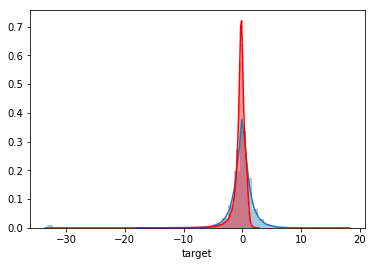

In [204]:
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')

In [206]:
t1 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==1]
t2 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==2]
t3 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t0 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t0 = t0.reset_index()
t0.sort_values('importance')

,feature,importance
217,purchase_amount_median_hist_month_1_hist_month_14,0.000000
107,new_purchase_date_year_Mode,0.000000
214,merchant_id_count_hist_month_1_hist_month_11,0.000000
216,purchase_amount_mode_hist_month_1_hist_month_12,1.726083
197,purchase_amount_sum_hist_month_1_hist_month_7,1.754882
205,purchase_amount_mean_hist_month_1_hist_month_8,1.769201
215,purchase_amount_mode_hist_month_1_hist_month_11,1.821272
208,purchase_amount_min_hist_month_1_hist_month_8,1.880137
211,purchase_amount_Range_hist_month_1_hist_month_9,2.083750
198,purchase_amount_mean_hist_month_1_hist_month_7,2.298051


In [211]:
df['hist_category_1_mean'].head()

card_id
C_ID_92a2005557    0.000000
C_ID_3d0044924f    0.096317
C_ID_d639edf6cd    0.000000
C_ID_186d6a6901    0.151899
C_ID_cdbd2c0db2    0.111940
Name: hist_category_1_mean, dtype: float64

Starting LightGBM. Train shape: (201917, 217), test shape: (123623, 217)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67571	test's rmse: 3.70795
[200]	train's rmse: 3.59991	test's rmse: 3.67173
[300]	train's rmse: 3.55233	test's rmse: 3.65841
[400]	train's rmse: 3.51769	test's rmse: 3.65119
[500]	train's rmse: 3.48972	test's rmse: 3.64697
[600]	train's rmse: 3.46578	test's rmse: 3.64415
[700]	train's rmse: 3.44362	test's rmse: 3.64251
[800]	train's rmse: 3.42215	test's rmse: 3.64125
[900]	train's rmse: 3.40233	test's rmse: 3.64045
[1000]	train's rmse: 3.38331	test's rmse: 3.63974
[1100]	train's rmse: 3.36641	test's rmse: 3.6395
[1200]	train's rmse: 3.34762	test's rmse: 3.63935
[1300]	train's rmse: 3.33154	test's rmse: 3.6392
[1400]	train's rmse: 3.3159	test's rmse: 3.639
[1500]	train's rmse: 3.29971	test's rmse: 3.63912
[1600]	train's rmse: 3.28309	test's rmse: 3.63913
Early stopping, best iteration is:
[1401]	train's rmse: 3.31563	test's rmse: 3.63898
Fold  1 RMSE : 3.638984


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66809	test's rmse: 3.72215
[200]	train's rmse: 3.58968	test's rmse: 3.69085
[300]	train's rmse: 3.5392	test's rmse: 3.68093
[400]	train's rmse: 3.50456	test's rmse: 3.67592
[500]	train's rmse: 3.47847	test's rmse: 3.67356
[600]	train's rmse: 3.45466	test's rmse: 3.67173
[700]	train's rmse: 3.43359	test's rmse: 3.67031
[800]	train's rmse: 3.41407	test's rmse: 3.67007
[900]	train's rmse: 3.39496	test's rmse: 3.66998
[1000]	train's rmse: 3.37641	test's rmse: 3.67005
Early stopping, best iteration is:
[871]	train's rmse: 3.4002	test's rmse: 3.66981
Fold  2 RMSE : 3.669814


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66842	test's rmse: 3.71832
[200]	train's rmse: 3.59024	test's rmse: 3.68759
[300]	train's rmse: 3.53878	test's rmse: 3.67665
[400]	train's rmse: 3.50505	test's rmse: 3.67129
[500]	train's rmse: 3.47784	test's rmse: 3.66822
[600]	train's rmse: 3.4535	test's rmse: 3.66643
[700]	train's rmse: 3.4327	test's rmse: 3.66546
[800]	train's rmse: 3.41367	test's rmse: 3.66489
[900]	train's rmse: 3.39539	test's rmse: 3.66524
[1000]	train's rmse: 3.3768	test's rmse: 3.665
Early stopping, best iteration is:
[800]	train's rmse: 3.41367	test's rmse: 3.66489
Fold  3 RMSE : 3.664887


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66552	test's rmse: 3.72287
[200]	train's rmse: 3.58544	test's rmse: 3.69155
[300]	train's rmse: 3.53384	test's rmse: 3.68088
[400]	train's rmse: 3.49882	test's rmse: 3.67602
[500]	train's rmse: 3.47212	test's rmse: 3.67374
[600]	train's rmse: 3.44884	test's rmse: 3.67196
[700]	train's rmse: 3.42739	test's rmse: 3.671
[800]	train's rmse: 3.40523	test's rmse: 3.67066
[900]	train's rmse: 3.38613	test's rmse: 3.67025
[1000]	train's rmse: 3.36867	test's rmse: 3.67028
[1100]	train's rmse: 3.35235	test's rmse: 3.67029
Early stopping, best iteration is:
[982]	train's rmse: 3.37193	test's rmse: 3.67014
Fold  4 RMSE : 3.670144
RMSE is 3.6609795351752434


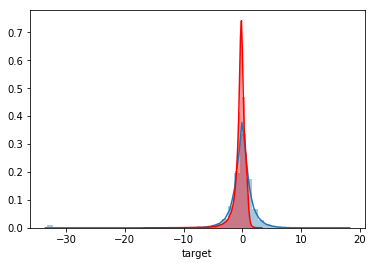

In [161]:
## eliminate again
## NO GOOD
non_importance = [*t0['feature'][t0['importance']==0]]
train.drop(non_importance, axis=1, inplace=True)
test.drop(non_importance, axis=1, inplace=True)
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')


Starting LightGBM. Train shape: (201917, 220), test shape: (123623, 220)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67587	test's rmse: 3.7067
[200]	train's rmse: 3.60027	test's rmse: 3.67116
[300]	train's rmse: 3.5513	test's rmse: 3.65764
[400]	train's rmse: 3.51613	test's rmse: 3.65034
[500]	train's rmse: 3.48915	test's rmse: 3.64651
[600]	train's rmse: 3.46469	test's rmse: 3.64379
[700]	train's rmse: 3.44179	test's rmse: 3.64183
[800]	train's rmse: 3.42069	test's rmse: 3.64075
[900]	train's rmse: 3.39987	test's rmse: 3.64004
[1000]	train's rmse: 3.38011	test's rmse: 3.63945
[1100]	train's rmse: 3.36228	test's rmse: 3.63919
[1200]	train's rmse: 3.3459	test's rmse: 3.63881
[1300]	train's rmse: 3.32984	test's rmse: 3.63899
[1400]	train's rmse: 3.31325	test's rmse: 3.63868
[1500]	train's rmse: 3.29647	test's rmse: 3.63879
[1600]	train's rmse: 3.281	test's rmse: 3.63882
Early stopping, best iteration is:
[1444]	train's rmse: 3.30569	test's rmse: 3.63858
Fold  1 RMSE : 3.638576


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66773	test's rmse: 3.72383
[200]	train's rmse: 3.58912	test's rmse: 3.69291
[300]	train's rmse: 3.53939	test's rmse: 3.68248
[400]	train's rmse: 3.50435	test's rmse: 3.67768
[500]	train's rmse: 3.47908	test's rmse: 3.67483
[600]	train's rmse: 3.45626	test's rmse: 3.67303
[700]	train's rmse: 3.43413	test's rmse: 3.6722
[800]	train's rmse: 3.41388	test's rmse: 3.67146
[900]	train's rmse: 3.39593	test's rmse: 3.67134
[1000]	train's rmse: 3.3771	test's rmse: 3.67171
[1100]	train's rmse: 3.35975	test's rmse: 3.67161
Early stopping, best iteration is:
[903]	train's rmse: 3.39561	test's rmse: 3.6713
Fold  2 RMSE : 3.671296


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66849	test's rmse: 3.71961
[200]	train's rmse: 3.59082	test's rmse: 3.68781
[300]	train's rmse: 3.54038	test's rmse: 3.67618
[400]	train's rmse: 3.50693	test's rmse: 3.67061
[500]	train's rmse: 3.47913	test's rmse: 3.66747
[600]	train's rmse: 3.455	test's rmse: 3.66537
[700]	train's rmse: 3.43375	test's rmse: 3.66415
[800]	train's rmse: 3.41333	test's rmse: 3.66346
[900]	train's rmse: 3.39366	test's rmse: 3.66306
[1000]	train's rmse: 3.37492	test's rmse: 3.66251
[1100]	train's rmse: 3.35698	test's rmse: 3.66241
[1200]	train's rmse: 3.33915	test's rmse: 3.66246
[1300]	train's rmse: 3.32294	test's rmse: 3.66237
[1400]	train's rmse: 3.30766	test's rmse: 3.66286
Early stopping, best iteration is:
[1224]	train's rmse: 3.33522	test's rmse: 3.66216
Fold  3 RMSE : 3.662164


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66526	test's rmse: 3.72134
[200]	train's rmse: 3.58671	test's rmse: 3.69097
[300]	train's rmse: 3.53622	test's rmse: 3.68036
[400]	train's rmse: 3.50139	test's rmse: 3.67461
[500]	train's rmse: 3.47295	test's rmse: 3.6723
[600]	train's rmse: 3.44946	test's rmse: 3.67074
[700]	train's rmse: 3.42776	test's rmse: 3.66965
[800]	train's rmse: 3.4069	test's rmse: 3.66894
[900]	train's rmse: 3.38697	test's rmse: 3.66857
[1000]	train's rmse: 3.37084	test's rmse: 3.66811
[1100]	train's rmse: 3.35266	test's rmse: 3.66789
[1200]	train's rmse: 3.33584	test's rmse: 3.66807
Early stopping, best iteration is:
[1039]	train's rmse: 3.3633	test's rmse: 3.66784
Fold  4 RMSE : 3.667843
RMSE is 3.659991830697809


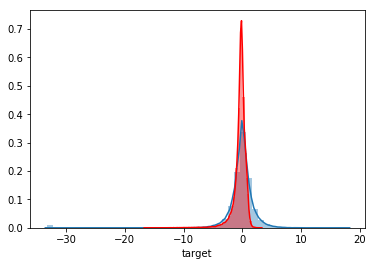

In [159]:
## feature elimination improves model performance!

#non_importance = [*t0['feature'][t0['importance']==0]]
#train.drop(non_importance, axis=1, inplace=True)
#test.drop(non_importance, axis=1, inplace=True)

sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')


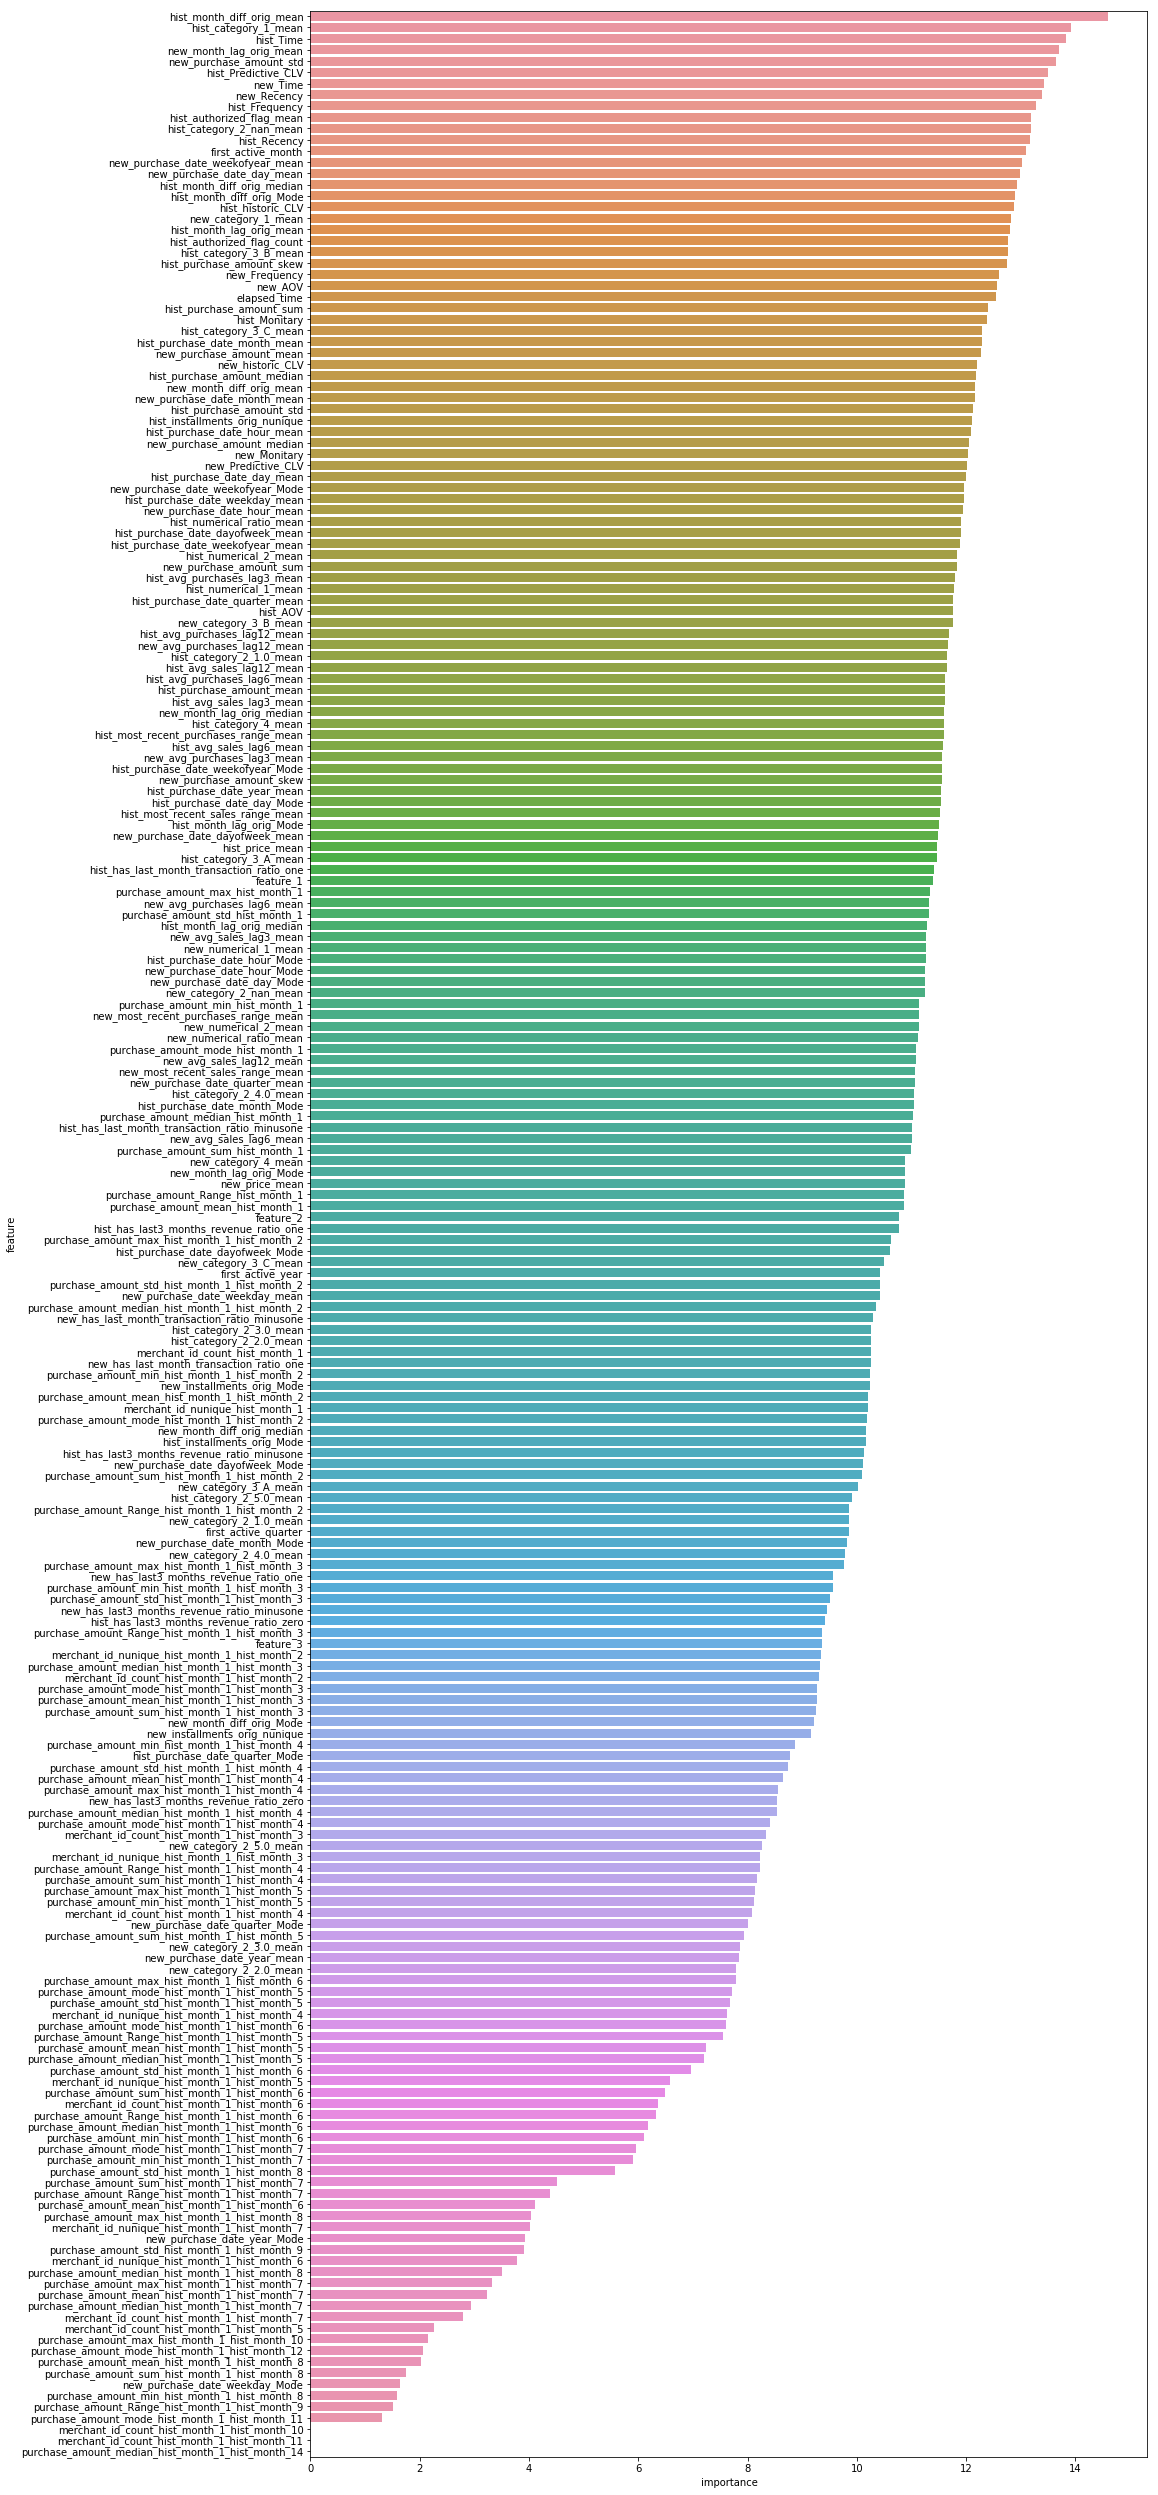

In [160]:
t1 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==1]
t2 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==2]
t3 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t0 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t0 = t0.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t0.sort_values(by="importance", ascending=False))
       

['feature_1',
 'feature_2',
 'feature_3',
 'first_active_month',
 'first_active_year',
 'first_active_quarter',
 'elapsed_time',
 'hist_Frequency',
 'hist_Monitary',
 'hist_Recency',
 'hist_Time',
 'hist_historic_CLV',
 'hist_AOV',
 'hist_Predictive_CLV',
 'new_Frequency',
 'new_Monitary',
 'new_Recency',
 'new_Time',
 'new_historic_CLV',
 'new_AOV',
 'new_Predictive_CLV',
 'hist_authorized_flag_count',
 'hist_authorized_flag_mean',
 'hist_category_1_mean',
 'hist_category_2_1.0_mean',
 'hist_category_2_2.0_mean',
 'hist_category_2_3.0_mean',
 'hist_category_2_4.0_mean',
 'hist_category_2_5.0_mean',
 'hist_category_2_nan_mean',
 'hist_category_3_A_mean',
 'hist_category_3_B_mean',
 'hist_category_3_C_mean',
 'hist_category_4_mean',
 'hist_most_recent_sales_range_mean',
 'hist_most_recent_purchases_range_mean',
 'hist_avg_sales_lag3_mean',
 'hist_avg_sales_lag6_mean',
 'hist_avg_sales_lag12_mean',
 'hist_avg_purchases_lag3_mean',
 'hist_avg_purchases_lag6_mean',
 'hist_avg_purchases_lag

Starting LightGBM. Train shape: (201917, 421), test shape: (123623, 421)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67636	test's rmse: 3.70731
[200]	train's rmse: 3.59973	test's rmse: 3.67147
[300]	train's rmse: 3.55186	test's rmse: 3.65796
[400]	train's rmse: 3.51795	test's rmse: 3.6514
[500]	train's rmse: 3.48996	test's rmse: 3.648
[600]	train's rmse: 3.46435	test's rmse: 3.64518
[700]	train's rmse: 3.44236	test's rmse: 3.64326
[800]	train's rmse: 3.42073	test's rmse: 3.64217
[900]	train's rmse: 3.39985	test's rmse: 3.64168
[1000]	train's rmse: 3.38059	test's rmse: 3.64131
[1100]	train's rmse: 3.36192	test's rmse: 3.6409
[1200]	train's rmse: 3.344	test's rmse: 3.64031
[1300]	train's rmse: 3.32663	test's rmse: 3.64032
[1400]	train's rmse: 3.31022	test's rmse: 3.64077
Early stopping, best iteration is:
[1222]	train's rmse: 3.33983	test's rmse: 3.64021
Fold  1 RMSE : 3.640214


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66773	test's rmse: 3.72294
[200]	train's rmse: 3.5882	test's rmse: 3.69271
[300]	train's rmse: 3.53749	test's rmse: 3.68139
[400]	train's rmse: 3.50274	test's rmse: 3.67641
[500]	train's rmse: 3.47777	test's rmse: 3.67387
[600]	train's rmse: 3.45478	test's rmse: 3.67216
[700]	train's rmse: 3.43353	test's rmse: 3.6711
[800]	train's rmse: 3.41357	test's rmse: 3.67034
[900]	train's rmse: 3.39402	test's rmse: 3.67016
[1000]	train's rmse: 3.37361	test's rmse: 3.67048
Early stopping, best iteration is:
[883]	train's rmse: 3.39713	test's rmse: 3.67009
Fold  2 RMSE : 3.670092


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66767	test's rmse: 3.71818
[200]	train's rmse: 3.58974	test's rmse: 3.68817
[300]	train's rmse: 3.53929	test's rmse: 3.67687
[400]	train's rmse: 3.50476	test's rmse: 3.67163
[500]	train's rmse: 3.4775	test's rmse: 3.66858
[600]	train's rmse: 3.45435	test's rmse: 3.66648
[700]	train's rmse: 3.43285	test's rmse: 3.66558
[800]	train's rmse: 3.41273	test's rmse: 3.66495
[900]	train's rmse: 3.39385	test's rmse: 3.6645
[1000]	train's rmse: 3.37579	test's rmse: 3.66433
[1100]	train's rmse: 3.35786	test's rmse: 3.66386
[1200]	train's rmse: 3.33912	test's rmse: 3.66393
[1300]	train's rmse: 3.32198	test's rmse: 3.66403
Early stopping, best iteration is:
[1149]	train's rmse: 3.34915	test's rmse: 3.66358
Fold  3 RMSE : 3.663585


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66466	test's rmse: 3.72166
[200]	train's rmse: 3.58524	test's rmse: 3.69064
[300]	train's rmse: 3.53483	test's rmse: 3.67935
[400]	train's rmse: 3.49997	test's rmse: 3.67439
[500]	train's rmse: 3.47153	test's rmse: 3.67153
[600]	train's rmse: 3.44815	test's rmse: 3.66994
[700]	train's rmse: 3.42679	test's rmse: 3.66879
[800]	train's rmse: 3.40546	test's rmse: 3.6683
[900]	train's rmse: 3.38595	test's rmse: 3.66792
[1000]	train's rmse: 3.36849	test's rmse: 3.66769
[1100]	train's rmse: 3.35235	test's rmse: 3.66791
[1200]	train's rmse: 3.33572	test's rmse: 3.66784
Early stopping, best iteration is:
[1015]	train's rmse: 3.36608	test's rmse: 3.6676
Fold  4 RMSE : 3.667595
RMSE is 3.6603906550489818


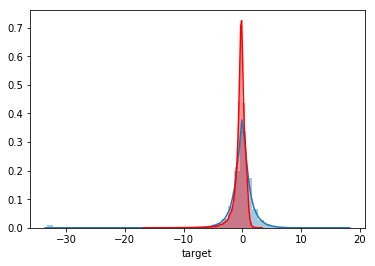

In [118]:
# fillna(0); make sure everything categorical features have positive values
## got 3.6615
### got much better result if I restricted categorical features to 'feature_..'', 'first_active_..'!
## got 3.6604
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')


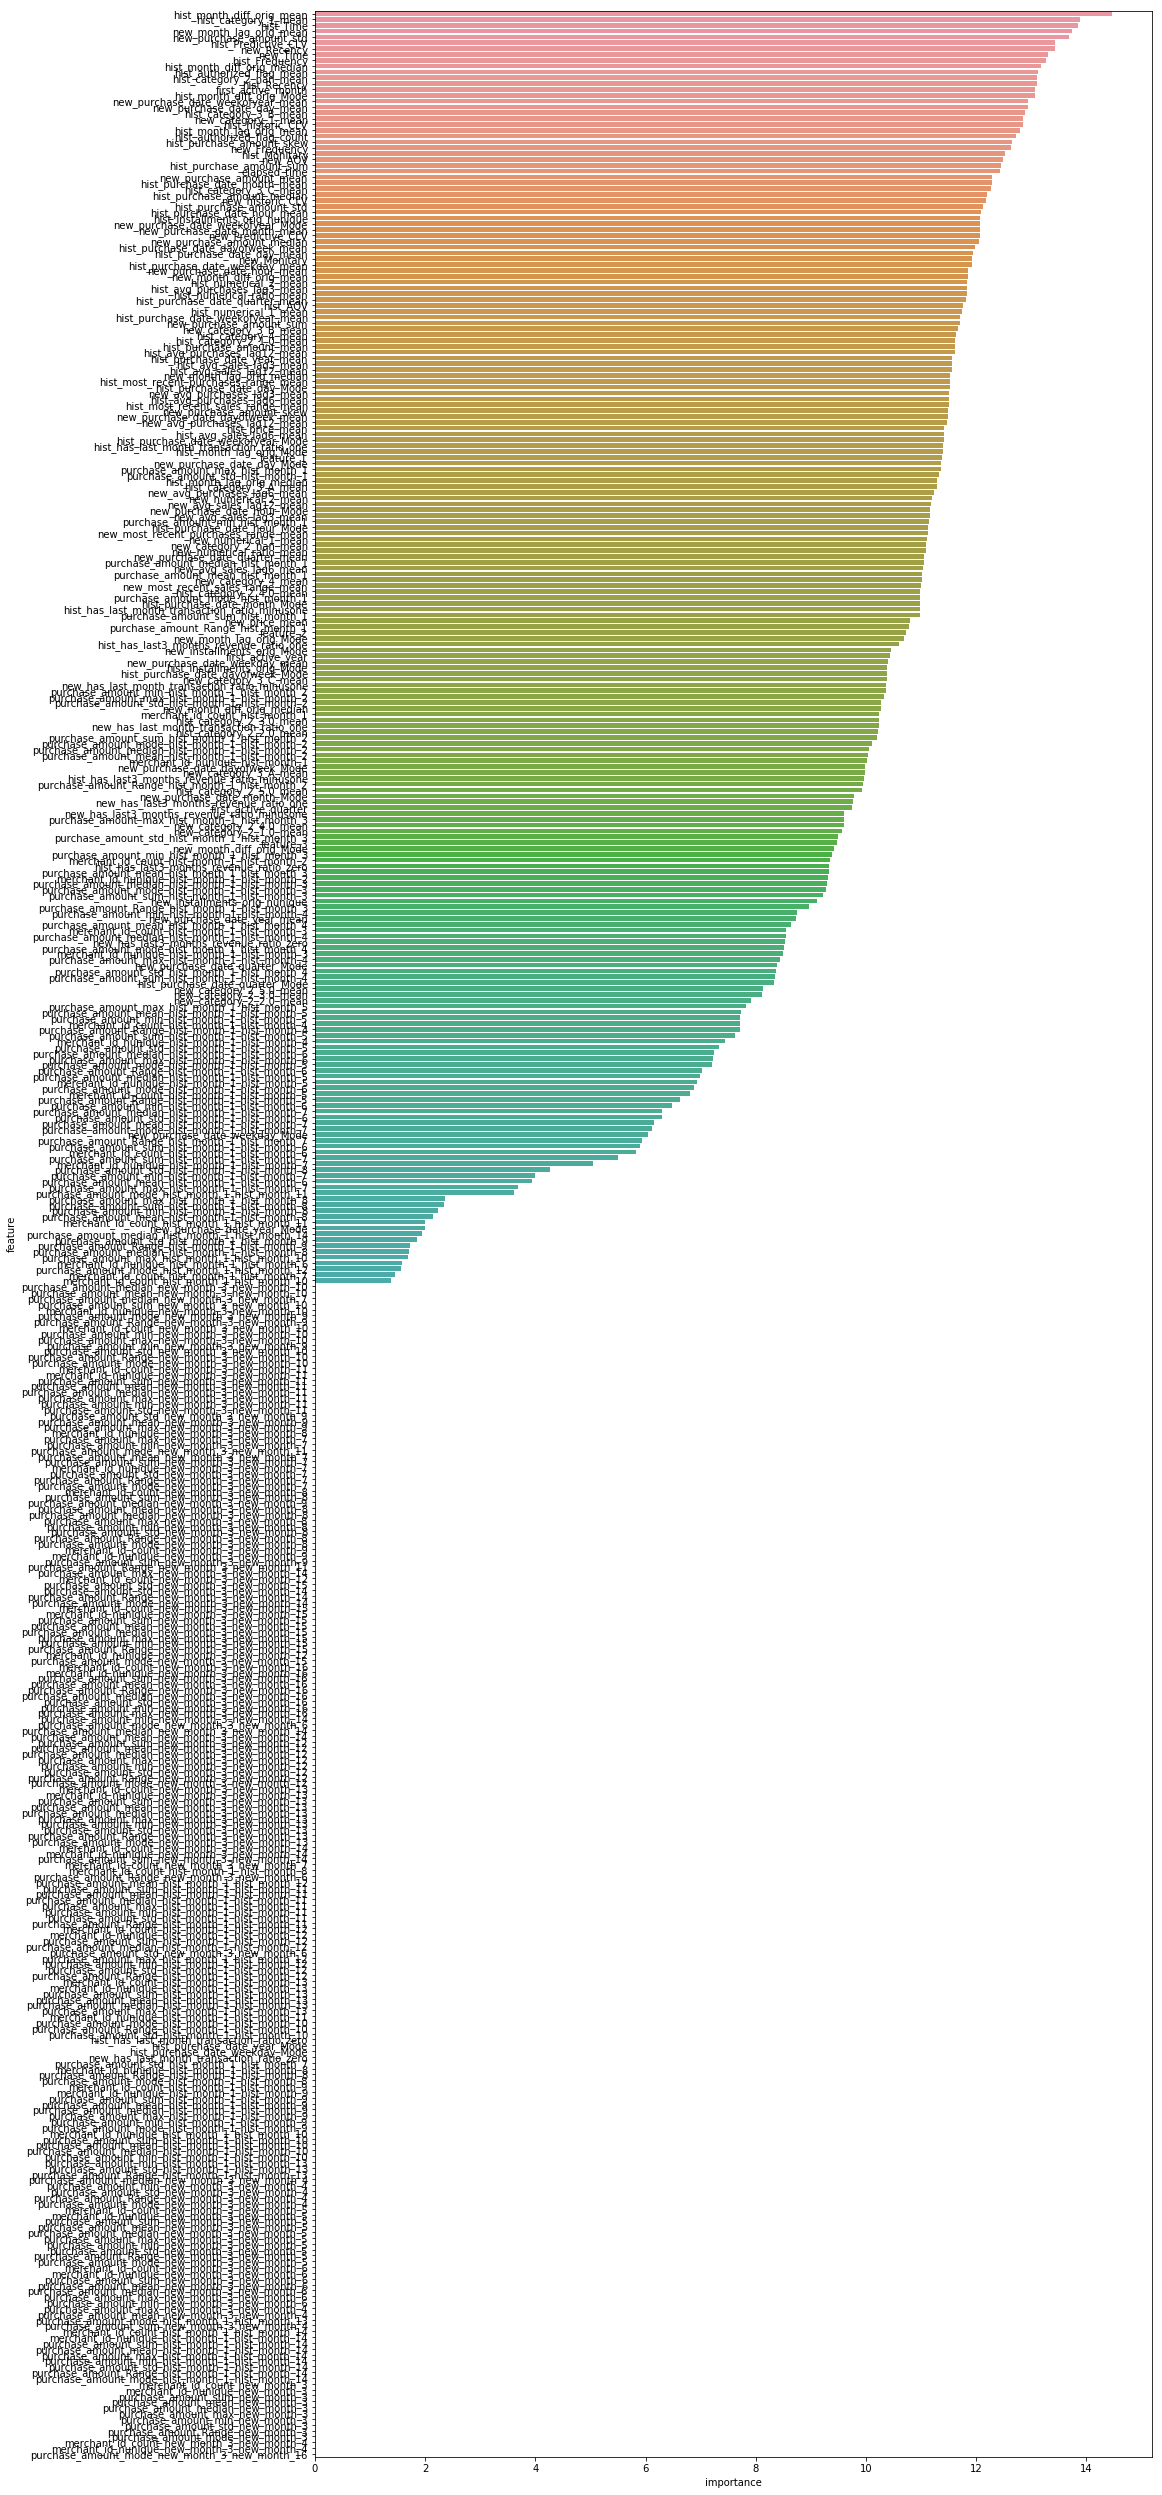

In [146]:
t1 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==1]
t2 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==2]
t3 = feature_importance_df[['feature', 'importance']][feature_importance_df['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t0 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t0 = t0.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t0.sort_values(by="importance", ascending=False))
       

Starting LightGBM. Train shape: (201917, 421), test shape: (123623, 421)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67542	test's rmse: 3.70756
[200]	train's rmse: 3.59783	test's rmse: 3.67365
[300]	train's rmse: 3.54848	test's rmse: 3.65965
[400]	train's rmse: 3.51194	test's rmse: 3.65335
[500]	train's rmse: 3.48319	test's rmse: 3.64981
[600]	train's rmse: 3.45753	test's rmse: 3.64721
[700]	train's rmse: 3.43601	test's rmse: 3.64579
[800]	train's rmse: 3.41548	test's rmse: 3.64467
[900]	train's rmse: 3.39758	test's rmse: 3.64432
[1000]	train's rmse: 3.3789	test's rmse: 3.64393
[1100]	train's rmse: 3.3618	test's rmse: 3.64404
[1200]	train's rmse: 3.34484	test's rmse: 3.64383
[1300]	train's rmse: 3.32821	test's rmse: 3.64386
Early stopping, best iteration is:
[1132]	train's rmse: 3.35634	test's rmse: 3.64379
Fold  1 RMSE : 3.643785


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66602	test's rmse: 3.72385
[200]	train's rmse: 3.58476	test's rmse: 3.69431
[300]	train's rmse: 3.53153	test's rmse: 3.68307
[400]	train's rmse: 3.4955	test's rmse: 3.67814
[500]	train's rmse: 3.46936	test's rmse: 3.67594
[600]	train's rmse: 3.44518	test's rmse: 3.67454
[700]	train's rmse: 3.42398	test's rmse: 3.67331
[800]	train's rmse: 3.40408	test's rmse: 3.6727
[900]	train's rmse: 3.3845	test's rmse: 3.67292
[1000]	train's rmse: 3.36522	test's rmse: 3.67277
Early stopping, best iteration is:
[807]	train's rmse: 3.40281	test's rmse: 3.67269
Fold  2 RMSE : 3.672690


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66594	test's rmse: 3.72012
[200]	train's rmse: 3.58599	test's rmse: 3.68971
[300]	train's rmse: 3.53493	test's rmse: 3.67924
[400]	train's rmse: 3.49894	test's rmse: 3.67372
[500]	train's rmse: 3.46956	test's rmse: 3.67148
[600]	train's rmse: 3.44407	test's rmse: 3.6702
[700]	train's rmse: 3.42244	test's rmse: 3.66935
[800]	train's rmse: 3.40328	test's rmse: 3.66889
[900]	train's rmse: 3.38599	test's rmse: 3.6687
[1000]	train's rmse: 3.36943	test's rmse: 3.6688
[1100]	train's rmse: 3.35283	test's rmse: 3.66862
[1200]	train's rmse: 3.33622	test's rmse: 3.66877
Early stopping, best iteration is:
[1083]	train's rmse: 3.35588	test's rmse: 3.66855
Fold  3 RMSE : 3.668555


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6637	test's rmse: 3.72126
[200]	train's rmse: 3.58263	test's rmse: 3.6917
[300]	train's rmse: 3.5305	test's rmse: 3.68196
[400]	train's rmse: 3.49255	test's rmse: 3.67771
[500]	train's rmse: 3.46306	test's rmse: 3.67557
[600]	train's rmse: 3.44008	test's rmse: 3.67433
[700]	train's rmse: 3.41696	test's rmse: 3.67324
[800]	train's rmse: 3.39624	test's rmse: 3.67266
[900]	train's rmse: 3.3777	test's rmse: 3.6726
[1000]	train's rmse: 3.36033	test's rmse: 3.67232
[1100]	train's rmse: 3.34323	test's rmse: 3.67234
[1200]	train's rmse: 3.32554	test's rmse: 3.67218
[1300]	train's rmse: 3.30902	test's rmse: 3.67243
Early stopping, best iteration is:
[1183]	train's rmse: 3.3287	test's rmse: 3.6721
Fold  4 RMSE : 3.672096
RMSE is 3.6643007549009656


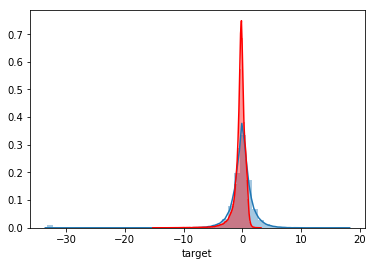

In [90]:
# mean => mean, mode => mode, all others => median:
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')

Starting LightGBM. Train shape: (201917, 421), test shape: (123623, 421)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67479	test's rmse: 3.70723
[200]	train's rmse: 3.59688	test's rmse: 3.67307
[300]	train's rmse: 3.54792	test's rmse: 3.65946
[400]	train's rmse: 3.51157	test's rmse: 3.65196
[500]	train's rmse: 3.48161	test's rmse: 3.64784
[600]	train's rmse: 3.45542	test's rmse: 3.64511
[700]	train's rmse: 3.43161	test's rmse: 3.643
[800]	train's rmse: 3.41088	test's rmse: 3.64182
[900]	train's rmse: 3.39241	test's rmse: 3.64068
[1000]	train's rmse: 3.37343	test's rmse: 3.6403
[1100]	train's rmse: 3.35629	test's rmse: 3.63941
[1200]	train's rmse: 3.3382	test's rmse: 3.63934
[1300]	train's rmse: 3.32105	test's rmse: 3.63915
[1400]	train's rmse: 3.30535	test's rmse: 3.6391
[1500]	train's rmse: 3.28973	test's rmse: 3.63909
[1600]	train's rmse: 3.27587	test's rmse: 3.63906
[1700]	train's rmse: 3.26095	test's rmse: 3.63893
[1800]	train's rmse: 3.246	test's rmse: 3.63896
Early stopping, best iteration is:
[1677]	train's rms

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66576	test's rmse: 3.72381
[200]	train's rmse: 3.58462	test's rmse: 3.69493
[300]	train's rmse: 3.53236	test's rmse: 3.68365
[400]	train's rmse: 3.49639	test's rmse: 3.67944
[500]	train's rmse: 3.46906	test's rmse: 3.67682
[600]	train's rmse: 3.44478	test's rmse: 3.67538
[700]	train's rmse: 3.42236	test's rmse: 3.67424
[800]	train's rmse: 3.40194	test's rmse: 3.67328
[900]	train's rmse: 3.383	test's rmse: 3.67316
[1000]	train's rmse: 3.36274	test's rmse: 3.67346
Early stopping, best iteration is:
[859]	train's rmse: 3.39136	test's rmse: 3.67301
Fold  2 RMSE : 3.673009


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66569	test's rmse: 3.7206
[200]	train's rmse: 3.58665	test's rmse: 3.68984
[300]	train's rmse: 3.53561	test's rmse: 3.67809
[400]	train's rmse: 3.49998	test's rmse: 3.67249
[500]	train's rmse: 3.47048	test's rmse: 3.66918
[600]	train's rmse: 3.44426	test's rmse: 3.66731
[700]	train's rmse: 3.42202	test's rmse: 3.66637
[800]	train's rmse: 3.40207	test's rmse: 3.66537
[900]	train's rmse: 3.38387	test's rmse: 3.66467
[1000]	train's rmse: 3.36497	test's rmse: 3.6645
[1100]	train's rmse: 3.34817	test's rmse: 3.66449
Early stopping, best iteration is:
[944]	train's rmse: 3.37525	test's rmse: 3.6644
Fold  3 RMSE : 3.664395


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66381	test's rmse: 3.72219
[200]	train's rmse: 3.58257	test's rmse: 3.69178
[300]	train's rmse: 3.52935	test's rmse: 3.68075
[400]	train's rmse: 3.49392	test's rmse: 3.67523
[500]	train's rmse: 3.46375	test's rmse: 3.67277
[600]	train's rmse: 3.43892	test's rmse: 3.6712
[700]	train's rmse: 3.41536	test's rmse: 3.66958
[800]	train's rmse: 3.395	test's rmse: 3.66863
[900]	train's rmse: 3.37651	test's rmse: 3.66815
[1000]	train's rmse: 3.3598	test's rmse: 3.66758
[1100]	train's rmse: 3.34308	test's rmse: 3.66751
[1200]	train's rmse: 3.32676	test's rmse: 3.66752
[1300]	train's rmse: 3.31005	test's rmse: 3.66774
Early stopping, best iteration is:
[1121]	train's rmse: 3.33971	test's rmse: 3.66737
Fold  4 RMSE : 3.667365
RMSE is 3.660914987407273


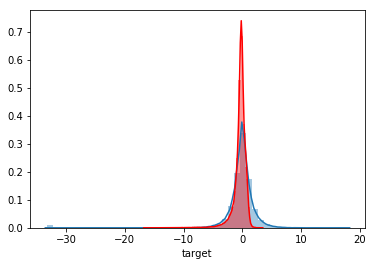

In [31]:
# fillna: all => 0
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')

Starting LightGBM. Train shape: (201917, 421), test shape: (123623, 421)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67238	test's rmse: 3.70636
[200]	train's rmse: 3.59293	test's rmse: 3.67134
[300]	train's rmse: 3.54408	test's rmse: 3.65772
[400]	train's rmse: 3.50815	test's rmse: 3.65073
[500]	train's rmse: 3.47817	test's rmse: 3.64699
[600]	train's rmse: 3.45237	test's rmse: 3.64473
[700]	train's rmse: 3.42963	test's rmse: 3.643
[800]	train's rmse: 3.40856	test's rmse: 3.64179
[900]	train's rmse: 3.3897	test's rmse: 3.64071
[1000]	train's rmse: 3.37149	test's rmse: 3.6398
[1100]	train's rmse: 3.35428	test's rmse: 3.63965
[1200]	train's rmse: 3.33704	test's rmse: 3.63938
[1300]	train's rmse: 3.32037	test's rmse: 3.6394
[1400]	train's rmse: 3.30384	test's rmse: 3.63963
Early stopping, best iteration is:
[1276]	train's rmse: 3.32425	test's rmse: 3.63925
Fold  1 RMSE : 3.639248


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66241	test's rmse: 3.72235
[200]	train's rmse: 3.58186	test's rmse: 3.69404
[300]	train's rmse: 3.52747	test's rmse: 3.68328
[400]	train's rmse: 3.48936	test's rmse: 3.67831
[500]	train's rmse: 3.46095	test's rmse: 3.67525
[600]	train's rmse: 3.43734	test's rmse: 3.67348
[700]	train's rmse: 3.41561	test's rmse: 3.67225
[800]	train's rmse: 3.39489	test's rmse: 3.67151
[900]	train's rmse: 3.37612	test's rmse: 3.67116
[1000]	train's rmse: 3.35743	test's rmse: 3.671
[1100]	train's rmse: 3.34063	test's rmse: 3.67107
[1200]	train's rmse: 3.32486	test's rmse: 3.67094
[1300]	train's rmse: 3.30964	test's rmse: 3.67108
Early stopping, best iteration is:
[1193]	train's rmse: 3.32606	test's rmse: 3.67088
Fold  2 RMSE : 3.670875


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66358	test's rmse: 3.71931
[200]	train's rmse: 3.58363	test's rmse: 3.6876
[300]	train's rmse: 3.53089	test's rmse: 3.67693
[400]	train's rmse: 3.49457	test's rmse: 3.67118
[500]	train's rmse: 3.46538	test's rmse: 3.66785
[600]	train's rmse: 3.43856	test's rmse: 3.6661
[700]	train's rmse: 3.41606	test's rmse: 3.66524
[800]	train's rmse: 3.39649	test's rmse: 3.66469
[900]	train's rmse: 3.37875	test's rmse: 3.66439
[1000]	train's rmse: 3.36143	test's rmse: 3.66435
[1100]	train's rmse: 3.34463	test's rmse: 3.66438
[1200]	train's rmse: 3.32854	test's rmse: 3.66439
Early stopping, best iteration is:
[1016]	train's rmse: 3.35834	test's rmse: 3.66419
Fold  3 RMSE : 3.664193


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66181	test's rmse: 3.72291
[200]	train's rmse: 3.57872	test's rmse: 3.69233
[300]	train's rmse: 3.52541	test's rmse: 3.68136
[400]	train's rmse: 3.48653	test's rmse: 3.67658
[500]	train's rmse: 3.45641	test's rmse: 3.67418
[600]	train's rmse: 3.4317	test's rmse: 3.6728
[700]	train's rmse: 3.40962	test's rmse: 3.67146
[800]	train's rmse: 3.39022	test's rmse: 3.67035
[900]	train's rmse: 3.3704	test's rmse: 3.67004
[1000]	train's rmse: 3.35377	test's rmse: 3.66997
[1100]	train's rmse: 3.33793	test's rmse: 3.66986
[1200]	train's rmse: 3.32188	test's rmse: 3.67002
Early stopping, best iteration is:
[1062]	train's rmse: 3.34344	test's rmse: 3.66973
Fold  4 RMSE : 3.669732
RMSE is 3.6610344710920377


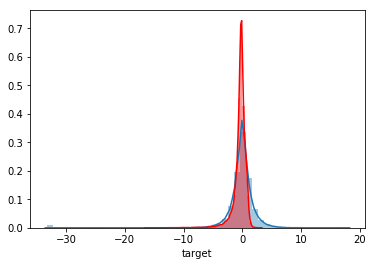

In [19]:
# fillna: cout/nunique/Range/std => 0

sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')


Starting LightGBM. Train shape: (201917, 393), test shape: (123623, 393)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67339	test's rmse: 3.70788
[200]	train's rmse: 3.59278	test's rmse: 3.67251
[300]	train's rmse: 3.54188	test's rmse: 3.65841
[400]	train's rmse: 3.50426	test's rmse: 3.65171
[500]	train's rmse: 3.47356	test's rmse: 3.64813
[600]	train's rmse: 3.44756	test's rmse: 3.64544
[700]	train's rmse: 3.4261	test's rmse: 3.64375
[800]	train's rmse: 3.405	test's rmse: 3.64234
[900]	train's rmse: 3.38564	test's rmse: 3.64155
[1000]	train's rmse: 3.36738	test's rmse: 3.64102
[1100]	train's rmse: 3.34973	test's rmse: 3.64053
[1200]	train's rmse: 3.3332	test's rmse: 3.64045
[1300]	train's rmse: 3.3173	test's rmse: 3.64016
[1400]	train's rmse: 3.30104	test's rmse: 3.63998
[1500]	train's rmse: 3.28427	test's rmse: 3.63976
[1600]	train's rmse: 3.26887	test's rmse: 3.6398
Early stopping, best iteration is:
[1456]	train's rmse: 3.29083	test's rmse: 3.63964
Fold  1 RMSE : 3.639645


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66252	test's rmse: 3.72275
[200]	train's rmse: 3.58045	test's rmse: 3.69307
[300]	train's rmse: 3.52682	test's rmse: 3.68374
[400]	train's rmse: 3.48952	test's rmse: 3.67833
[500]	train's rmse: 3.46104	test's rmse: 3.67599
[600]	train's rmse: 3.4357	test's rmse: 3.67428
[700]	train's rmse: 3.41349	test's rmse: 3.67305
[800]	train's rmse: 3.39408	test's rmse: 3.67236
[900]	train's rmse: 3.37507	test's rmse: 3.67174
[1000]	train's rmse: 3.35574	test's rmse: 3.67167
[1100]	train's rmse: 3.3395	test's rmse: 3.67164
Early stopping, best iteration is:
[991]	train's rmse: 3.35728	test's rmse: 3.67159
Fold  2 RMSE : 3.671587


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66497	test's rmse: 3.71972
[200]	train's rmse: 3.58306	test's rmse: 3.6882
[300]	train's rmse: 3.53152	test's rmse: 3.67756
[400]	train's rmse: 3.49434	test's rmse: 3.67208
[500]	train's rmse: 3.46479	test's rmse: 3.66905
[600]	train's rmse: 3.43976	test's rmse: 3.66739
[700]	train's rmse: 3.41769	test's rmse: 3.66641
[800]	train's rmse: 3.39646	test's rmse: 3.66563
[900]	train's rmse: 3.37786	test's rmse: 3.66548
[1000]	train's rmse: 3.36039	test's rmse: 3.66568
Early stopping, best iteration is:
[838]	train's rmse: 3.38894	test's rmse: 3.66536
Fold  3 RMSE : 3.665360


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66033	test's rmse: 3.72207
[200]	train's rmse: 3.5793	test's rmse: 3.69116
[300]	train's rmse: 3.52546	test's rmse: 3.68149
[400]	train's rmse: 3.48791	test's rmse: 3.67745
[500]	train's rmse: 3.45779	test's rmse: 3.67464
[600]	train's rmse: 3.43302	test's rmse: 3.67294
[700]	train's rmse: 3.40948	test's rmse: 3.67138
[800]	train's rmse: 3.39042	test's rmse: 3.67057
[900]	train's rmse: 3.37321	test's rmse: 3.67018
[1000]	train's rmse: 3.35643	test's rmse: 3.67021
[1100]	train's rmse: 3.3406	test's rmse: 3.67003
[1200]	train's rmse: 3.32379	test's rmse: 3.66979
[1300]	train's rmse: 3.30824	test's rmse: 3.67006
Early stopping, best iteration is:
[1184]	train's rmse: 3.32602	test's rmse: 3.66972
Fold  4 RMSE : 3.669721
RMSE is 3.6616008071245267


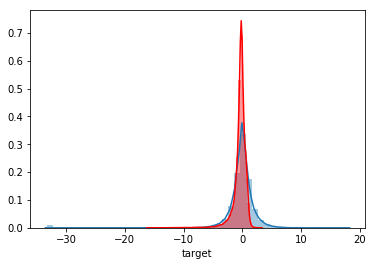

In [235]:
sub_preds_1, feature_importance_df = kfold_lightgbm(train, test, num_folds=4, stratified=True, debug=False)  
sns.distplot(train['target'])
sns.distplot(sub_preds_1, color='r')


In [213]:
df.head()

,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active_year,first_active_quarter,elapsed_time,hist_Frequency,hist_Monitary,hist_Recency,hist_Time,hist_historic_CLV,hist_AOV,hist_Predictive_CLV,new_Frequency,new_Monitary,new_Recency,new_Time,new_historic_CLV,new_AOV,new_Predictive_CLV,hist_authorized_flag_count,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_2_nan_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_category_4_mean,hist_most_recent_sales_range_mean,hist_most_recent_purchases_range_mean,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_mean,hist_numerical_1_mean,hist_numerical_2_mean,hist_numerical_ratio_mean,hist_price_mean,hist_has_last_month_transaction_ratio_one,hist_has_last_month_transaction_ratio_zero,hist_has_last_month_transaction_ratio_minusone,hist_has_last3_months_revenue_ratio_one,hist_has_last3_months_revenue_ratio_zero,hist_has_last3_months_revenue_ratio_minusone,hist_purchase_date_year_mean,hist_purchase_date_year_Mode,hist_purchase_date_month_mean,hist_purchase_date_month_Mode,hist_purchase_date_day_mean,hist_purchase_date_day_Mode,hist_purchase_date_dayofweek_mean,hist_purchase_date_dayofweek_Mode,hist_purchase_date_hour_mean,hist_purchase_date_hour_Mode,hist_purchase_date_weekofyear_mean,hist_purchase_date_weekofyear_Mode,hist_purchase_date_weekday_mean,hist_purchase_date_weekday_Mode,hist_purchase_date_quarter_mean,hist_purchase_date_quarter_Mode,hist_month_diff_orig_mean,hist_month_diff_orig_median,hist_month_diff_orig_Mode,hist_month_lag_orig_mean,hist_month_lag_orig_median,hist_month_lag_orig_Mode,hist_installments_orig_nunique,hist_installments_orig_Mode,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_std,hist_purchase_amount_skew,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_2_nan_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_category_4_mean,new_most_recent_sales_range_mean,new_most_recent_purchases_range_mean,new_avg_sales_lag3_mean,new_avg_sales_lag6_mean,new_avg_sales_lag12_mean,new_avg_purchases_lag3_mean,new_avg_purchases_lag6_mean,new_avg_purchases_lag12_mean,new_numerical_1_mean,new_numerical_2_mean,new_numerical_ratio_mean,new_price_mean,new_has_last_month_transaction_ratio_one,new_has_last_month_transaction_ratio_zero,new_has_last_month_transaction_ratio_minusone,new_has_last3_months_revenue_ratio_one,new_has_last3_months_revenue_ratio_zero,new_has_last3_months_revenue_ratio_minusone,new_purchase_date_year_mean,new_purchase_date_year_Mode,new_purchase_date_month_mean,new_purchase_date_month_Mode,new_purchase_date_day_mean,new_purchase_date_day_Mode,new_purchase_date_dayofweek_mean,new_purchase_date_dayofweek_Mode,new_purchase_date_hour_mean,new_purchase_date_hour_Mode,new_purchase_date_weekofyear_mean,new_purchase_date_weekofyear_Mode,new_purchase_date_weekday_mean,new_purchase_date_weekday_Mode,new_purchase_date_quarter_mean,new_purchase_date_quarter_Mode,new_month_diff_orig_mean,new_month_diff_orig_median,new_month_diff_orig_Mode,new_month_lag_orig_mean,new_month_lag_orig_median,new_month_lag_orig_Mode,new_installments_orig_nunique,new_installments_orig_Mode,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_std,new_purchase_amount_skew,merchant_id_count_hist_month_1,purchase_amount_sum_hist_month_1,purchase_amount_mean_hist_month_1,purchase_amount_median_hist_month_1,purchase_amount_max_hist_month_1,purchase_amount_min_hist_month_1,purchase_amount_std_hist_month_1,purchase_amount_Range_hist_month_1,purchase_amount_mode_hist_month_1,merchant_id_count_hist_m

In [230]:
df['hist_installments_orig_Mode'].value_counts()
#'hist_month_lag_orig_Mode', 'hist_month_diff_orig_Mode', 'hist_installments_orig_Mode', 'new_month_lag_orig_Mode', 'new_month_diff_orig_Mode', 'new_installments_orig_Mode', 


 1     162038
 0     154712
 3       2757
 2       2462
 10       845
 4        611
 6        608
-1        603
 5        412
 12       364
 8         67
 7         43
 9         17
 11         1
Name: hist_installments_orig_Mode, dtype: int64

In [228]:
for col in df.columns:
    if 'Mode' in col:
        print(col)

hist_purchase_date_year_Mode
hist_purchase_date_month_Mode
hist_purchase_date_day_Mode
hist_purchase_date_dayofweek_Mode
hist_purchase_date_hour_Mode
hist_purchase_date_weekofyear_Mode
hist_purchase_date_weekday_Mode
hist_purchase_date_quarter_Mode
hist_month_diff_orig_Mode
hist_month_lag_orig_Mode
hist_installments_orig_Mode
new_purchase_date_year_Mode
new_purchase_date_month_Mode
new_purchase_date_day_Mode
new_purchase_date_dayofweek_Mode
new_purchase_date_hour_Mode
new_purchase_date_weekofyear_Mode
new_purchase_date_weekday_Mode
new_purchase_date_quarter_Mode
new_month_diff_orig_Mode
new_month_lag_orig_Mode
new_installments_orig_Mode


In [227]:
df.isna().sum()

feature_1                                                 0
feature_2                                                 0
feature_3                                                 0
first_active_month                                        1
outliers                                             123623
target                                               123623
first_active_year                                         1
first_active_quarter                                      1
elapsed_time                                              1
hist_Frequency                                            0
hist_Monitary                                             0
hist_Recency                                              0
hist_Time                                                 0
hist_historic_CLV                                         0
hist_AOV                                                  0
hist_Predictive_CLV                                       0
new_Frequency                           

In [221]:
for col in df.columns:
    if 'merchant_id_count' in col:
        df[col] = df[col].fillna(0)
    
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]


In [197]:
def LGB_CV(
          learning_rate,
          subsample,
          colsample_bytree,
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_freq,
          bagging_fraction,
          reg_alpha,
          reg_lambda,
          min_child_weight,
          min_split_gain,
          top_rate,
         ):
    
    #categorical_features = ['feature_1', 'feature_2', 'feature_3','first_active_year', 'first_active_month', 'hist_month_lag_orig_Mode', 'hist_month_diff_orig_Mode', 'hist_installments_orig_Mode', 'new_month_lag_orig_Mode', 'new_month_diff_orig_Mode', 'new_installments_orig_Mode']
    categorical_features = ['feature_1', 'feature_2', 'feature_3','first_active_year', 'first_active_month', 'first_active_quarter']

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=326)
    oof = np.zeros(train.shape[0])
    
    feats = [f for f in train.columns if f not in FEATS_EXCLUDED]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], train['outliers'])):
        
        print("fold n°{}".format(n_fold))
        
        train_x, train_y = train[feats].iloc[train_idx], train['target'].iloc[train_idx]
        valid_x, valid_y = train[feats].iloc[valid_idx], train['target'].iloc[valid_idx]
        trn_data = lgb.Dataset(train_x,
                               label=train_y,
                               categorical_feature=categorical_features)
        val_data = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            "boosting": "goss",
            "feature_fraction": feature_fraction,
            
            "metric": 'rmse',
            "reg_alpha": reg_alpha,
            "reg_lambda": reg_lambda,
            "verbosity": -1,
            "n_jobs": -1,
            'learning_rate': learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "min_child_weight": min_child_weight,
            "min_split_gain": min_split_gain,
            "top_rate": top_rate,
            "other_rate": 1-top_rate,
            'seed':int(2**n_fold),
               
            'drop_seed':int(2**n_fold),
            'feature_fraction_seed': int(2**n_fold),
            #"bagging_freq": int(bagging_freq),
            #"bagging_fraction": bagging_fraction ,
            #"bagging_seed": 11,
            #'bagging_seed':int(2**n_fold),
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[valid_idx] = clf.predict(train.iloc[valid_idx][feats],
                                   num_iteration=clf.best_iteration)
        
        del clf, train_idx, valid_idx
        gc.collect()
        
    return -mean_squared_error(oof, train['target'])**0.5


In [198]:
LGB_BO = BayesianOptimization(LGB_CV, {
    'learning_rate': (0.001,0.01),
    'subsample': (0.7,1.0),
    'colsample_bytree': (0.4,1.0),
    'max_depth': (5, 12),
    'num_leaves': (63, 128),
    'min_data_in_leaf': (10, 20),
    'feature_fraction': (0.3, 0.9),
    'bagging_freq': (1,10),
    'bagging_fraction': (0.7, 1.0),
    'reg_alpha': (0,30),
    'reg_lambda': (5, 30),
    "min_child_weight": (10,150),
    "min_split_gain": (10,100),
    "top_rate": (0.0,1.0),
    })

In [200]:
%%time
## switch to goss, try with shape[1]==220
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=200, acq='ei', xi=0.0)
    

|   iter    |  target   | baggin... | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | top_rate  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60887	valid_1's rmse: 3.65133
[1000]	training's rmse: 3.55388	valid_1's rmse: 3.63456
[1500]	training's rmse: 3.52899	valid_1's rmse: 3.63074
Early stopping, best iteration is:
[1506]	training's rmse: 3.52897	valid_1's rmse: 3.63073
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59219	valid_1's rmse: 3.69432
[1000]	training's rmse: 3.53225	valid_1's rmse: 3.68137
[1500]	training's rmse: 3.5039	valid_1's rmse: 3.67857
Early stopping, best iteration is:
[1533]	tr

[2500]	training's rmse: 3.28273	valid_1's rmse: 3.68455
Early stopping, best iteration is:
[2621]	training's rmse: 3.27223	valid_1's rmse: 3.68433
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57427	valid_1's rmse: 3.6968
[1000]	training's rmse: 3.46362	valid_1's rmse: 3.67701
[1500]	training's rmse: 3.39071	valid_1's rmse: 3.67103
[2000]	training's rmse: 3.33358	valid_1's rmse: 3.66845
[2500]	training's rmse: 3.28592	valid_1's rmse: 3.66728
[3000]	training's rmse: 3.24446	valid_1's rmse: 3.66677
[3500]	training's rmse: 3.20527	valid_1's rmse: 3.66651
Early stopping, best iteration is:
[3366]	training's rmse: 3.2159	valid_1's rmse: 3.66643
|  5        | -3.658    |  0.7313   |  3.03     |  0.4167   |  0.457    |  0.00377  |  9.608    |  12.6     |  11.23    |  10.77    |  63.43    |  2.407    |  18.98    |  0.7958   |  0.2879   |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59687	vali

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64034	valid_1's rmse: 3.64769
[1000]	training's rmse: 3.60243	valid_1's rmse: 3.63481
[1500]	training's rmse: 3.57536	valid_1's rmse: 3.63102
[2000]	training's rmse: 3.5525	valid_1's rmse: 3.62912
[2500]	training's rmse: 3.5307	valid_1's rmse: 3.62833
[3000]	training's rmse: 3.51016	valid_1's rmse: 3.62796
Early stopping, best iteration is:
[2807]	training's rmse: 3.51832	valid_1's rmse: 3.62771
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62718	valid_1's rmse: 3.69049
[1000]	training's rmse: 3.58802	valid_1's rmse: 3.68142
[1500]	training's rmse: 3.55939	valid_1's rmse: 3.67814
[2000]	training's rmse: 3.53558	valid_1's rmse: 3.67718
[2500]	training's rmse: 3.51496	valid_1's rmse: 3.67666
[3000]	training's rmse: 3.49595	valid_1's rmse: 3.67674
Early stopping, best iteration is:
[2823]	training's rmse: 3.50243	valid_1's rmse: 3.67654
fold n

fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61561	valid_1's rmse: 3.69161
[1000]	training's rmse: 3.57548	valid_1's rmse: 3.68352
[1500]	training's rmse: 3.5485	valid_1's rmse: 3.68125
[2000]	training's rmse: 3.52133	valid_1's rmse: 3.68025
[2500]	training's rmse: 3.49698	valid_1's rmse: 3.67997
Early stopping, best iteration is:
[2343]	training's rmse: 3.50471	valid_1's rmse: 3.67984
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62037	valid_1's rmse: 3.68052
[1000]	training's rmse: 3.57889	valid_1's rmse: 3.67185
[1500]	training's rmse: 3.55009	valid_1's rmse: 3.66895
Early stopping, best iteration is:
[1765]	training's rmse: 3.53664	valid_1's rmse: 3.66843
|  12       | -3.66     |  0.9123   |  3.701    |  0.8507   |  0.3646   |  0.009717 |  5.713    |  145.6    |  16.72    |  10.56    |  64.34    |  1.787    |  25.82    |  0.9291   |  0.9188   |
fold n°0
Training until validation 

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.52377	valid_1's rmse: 3.6379
Early stopping, best iteration is:
[707]	training's rmse: 3.51212	valid_1's rmse: 3.63395
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5073	valid_1's rmse: 3.68526
Early stopping, best iteration is:
[741]	training's rmse: 3.49315	valid_1's rmse: 3.68251
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.52044	valid_1's rmse: 3.65256
Early stopping, best iteration is:
[730]	training's rmse: 3.50871	valid_1's rmse: 3.64949
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50506	valid_1's rmse: 3.68998
Early stopping, best iteration is:
[735]	training's rmse: 3.49284	valid_1's rmse: 3.68772
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50982	valid_1's rmse: 3.67661
Early s

Early stopping, best iteration is:
[2592]	training's rmse: 3.54517	valid_1's rmse: 3.68335
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64795	valid_1's rmse: 3.69449
[1000]	training's rmse: 3.60851	valid_1's rmse: 3.6794
[1500]	training's rmse: 3.584	valid_1's rmse: 3.67463
[2000]	training's rmse: 3.56395	valid_1's rmse: 3.67257
[2500]	training's rmse: 3.54675	valid_1's rmse: 3.67195
Early stopping, best iteration is:
[2459]	training's rmse: 3.54815	valid_1's rmse: 3.6719
|  19       | -3.661    |  0.8838   |  8.608    |  0.8575   |  0.8464   |  0.005262 |  5.009    |  131.7    |  17.44    |  10.07    |  73.98    |  0.8295   |  27.77    |  0.8064   |  0.967    |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.72959	valid_1's rmse: 3.74121
[1000]	training's rmse: 3.65997	valid_1's rmse: 3.69406
[1500]	training's rmse: 3.61	valid_1's rmse: 3.66895
[2000]	training's rmse: 3.57059	valid_1's

[500]	training's rmse: 3.68232	valid_1's rmse: 3.7157
[1000]	training's rmse: 3.60493	valid_1's rmse: 3.67757
[1500]	training's rmse: 3.55627	valid_1's rmse: 3.66203
[2000]	training's rmse: 3.52105	valid_1's rmse: 3.65432
[2500]	training's rmse: 3.49327	valid_1's rmse: 3.65008
[3000]	training's rmse: 3.46909	valid_1's rmse: 3.64748
[3500]	training's rmse: 3.44693	valid_1's rmse: 3.64584
[4000]	training's rmse: 3.42636	valid_1's rmse: 3.64481
[4500]	training's rmse: 3.40734	valid_1's rmse: 3.64391
[5000]	training's rmse: 3.39002	valid_1's rmse: 3.6433
[5500]	training's rmse: 3.37337	valid_1's rmse: 3.64294
Early stopping, best iteration is:
[5461]	training's rmse: 3.37462	valid_1's rmse: 3.64289
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67347	valid_1's rmse: 3.73536
[1000]	training's rmse: 3.59477	valid_1's rmse: 3.70595
[1500]	training's rmse: 3.54438	valid_1's rmse: 3.69561
[2000]	training's rmse: 3.50853	valid_1's rmse: 3.69056
[

[1000]	training's rmse: 3.38736	valid_1's rmse: 3.68728
Early stopping, best iteration is:
[1089]	training's rmse: 3.37123	valid_1's rmse: 3.6867
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50029	valid_1's rmse: 3.67829
[1000]	training's rmse: 3.38839	valid_1's rmse: 3.67156
Early stopping, best iteration is:
[1008]	training's rmse: 3.38689	valid_1's rmse: 3.67152
|  24       | -3.661    |  0.9589   |  8.02     |  0.5466   |  0.8738   |  0.007161 |  11.02    |  146.9    |  12.31    |  10.0     |  73.0     |  27.32    |  28.03    |  0.8721   |  0.7247   |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66434	valid_1's rmse: 3.66365
[1000]	training's rmse: 3.6243	valid_1's rmse: 3.64199
[1500]	training's rmse: 3.59989	valid_1's rmse: 3.63519
[2000]	training's rmse: 3.57809	valid_1's rmse: 3.63135
[2500]	training's rmse: 3.55842	valid_1's rmse: 3.6294
[3000]	training's rmse: 3.5403	valid_

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61229	valid_1's rmse: 3.64294
[1000]	training's rmse: 3.56112	valid_1's rmse: 3.62888
[1500]	training's rmse: 3.5221	valid_1's rmse: 3.62385
[2000]	training's rmse: 3.49011	valid_1's rmse: 3.62268
Early stopping, best iteration is:
[2295]	training's rmse: 3.47171	valid_1's rmse: 3.62218
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5957	valid_1's rmse: 3.68856
[1000]	training's rmse: 3.54311	valid_1's rmse: 3.67924
[1500]	training's rmse: 3.50315	valid_1's rmse: 3.6771
[2000]	training's rmse: 3.46944	valid_1's rmse: 3.67653
Early stopping, best iteration is:
[2014]	training's rmse: 3.4686	valid_1's rmse: 3.67649
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60422	valid_1's rmse: 3.66008
[1000]	training's rmse: 3.55396	valid_1's rmse: 3.65027
[1500]	training's rmse: 3.51938	valid_1's rmse: 3

fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55442	valid_1's rmse: 3.67766
[1000]	training's rmse: 3.48918	valid_1's rmse: 3.66772
[1500]	training's rmse: 3.44811	valid_1's rmse: 3.66564
[2000]	training's rmse: 3.41183	valid_1's rmse: 3.66512
Early stopping, best iteration is:
[1887]	training's rmse: 3.41976	valid_1's rmse: 3.66502
|  31       | -3.659    |  0.9432   |  1.319    |  0.9798   |  0.6672   |  0.006274 |  7.126    |  138.9    |  18.42    |  12.93    |  125.7    |  0.5441   |  29.93    |  0.7118   |  0.8461   |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4489	valid_1's rmse: 3.64966
[1000]	training's rmse: 3.27464	valid_1's rmse: 3.63001
[1500]	training's rmse: 3.1508	valid_1's rmse: 3.62476
[2000]	training's rmse: 3.0582	valid_1's rmse: 3.62312
Early stopping, best iteration is:
[2265]	training's rmse: 3.01886	valid_1's rmse: 3.62277
fold n°1
Training until validation sc

[4500]	training's rmse: 3.47807	valid_1's rmse: 3.64535
Early stopping, best iteration is:
[4375]	training's rmse: 3.48147	valid_1's rmse: 3.64533
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64916	valid_1's rmse: 3.71009
[1000]	training's rmse: 3.59411	valid_1's rmse: 3.69329
[1500]	training's rmse: 3.56528	valid_1's rmse: 3.68694
[2000]	training's rmse: 3.54251	valid_1's rmse: 3.68461
[2500]	training's rmse: 3.52529	valid_1's rmse: 3.68328
[3000]	training's rmse: 3.51015	valid_1's rmse: 3.6829
Early stopping, best iteration is:
[2982]	training's rmse: 3.51078	valid_1's rmse: 3.68287
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65088	valid_1's rmse: 3.70368
[1000]	training's rmse: 3.59542	valid_1's rmse: 3.68163
[1500]	training's rmse: 3.56686	valid_1's rmse: 3.67494
[2000]	training's rmse: 3.54495	valid_1's rmse: 3.67181
[2500]	training's rmse: 3.52451	valid_1's rmse: 3.67048
[3000

Early stopping, best iteration is:
[7677]	training's rmse: 3.2723	valid_1's rmse: 3.6835
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70795	valid_1's rmse: 3.75
[1000]	training's rmse: 3.62935	valid_1's rmse: 3.71105
[1500]	training's rmse: 3.57379	valid_1's rmse: 3.69336
[2000]	training's rmse: 3.53017	valid_1's rmse: 3.68396
[2500]	training's rmse: 3.49442	valid_1's rmse: 3.67808
[3000]	training's rmse: 3.46409	valid_1's rmse: 3.67457
[3500]	training's rmse: 3.43738	valid_1's rmse: 3.67253
[4000]	training's rmse: 3.41277	valid_1's rmse: 3.67106
[4500]	training's rmse: 3.39048	valid_1's rmse: 3.66989
[5000]	training's rmse: 3.36983	valid_1's rmse: 3.66892
[5500]	training's rmse: 3.35031	valid_1's rmse: 3.66806
[6000]	training's rmse: 3.33205	valid_1's rmse: 3.66724
[6500]	training's rmse: 3.31464	valid_1's rmse: 3.66666
[7000]	training's rmse: 3.298	valid_1's rmse: 3.66613
[7500]	training's rmse: 3.2821	valid_1's rmse: 3.66568
[8000]

Early stopping, best iteration is:
[8034]	training's rmse: 3.54294	valid_1's rmse: 3.62776
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70849	valid_1's rmse: 3.73581
[1000]	training's rmse: 3.66257	valid_1's rmse: 3.70626
[1500]	training's rmse: 3.63869	valid_1's rmse: 3.69476
[2000]	training's rmse: 3.62211	valid_1's rmse: 3.689
[2500]	training's rmse: 3.60891	valid_1's rmse: 3.68555
[3000]	training's rmse: 3.59897	valid_1's rmse: 3.68331
[3500]	training's rmse: 3.59056	valid_1's rmse: 3.68174
[4000]	training's rmse: 3.5824	valid_1's rmse: 3.68028
[4500]	training's rmse: 3.57465	valid_1's rmse: 3.67916
[5000]	training's rmse: 3.56716	valid_1's rmse: 3.67837
[5500]	training's rmse: 3.56022	valid_1's rmse: 3.67776
[6000]	training's rmse: 3.55348	valid_1's rmse: 3.67743
[6500]	training's rmse: 3.5467	valid_1's rmse: 3.67719
[7000]	training's rmse: 3.54034	valid_1's rmse: 3.67693
[7500]	training's rmse: 3.53427	valid_1's rmse: 3.67674
[8

[2500]	training's rmse: 3.58605	valid_1's rmse: 3.63109
[3000]	training's rmse: 3.57245	valid_1's rmse: 3.62955
[3500]	training's rmse: 3.56002	valid_1's rmse: 3.62829
[4000]	training's rmse: 3.54802	valid_1's rmse: 3.62744
[4500]	training's rmse: 3.53666	valid_1's rmse: 3.62685
[5000]	training's rmse: 3.52526	valid_1's rmse: 3.62661
Early stopping, best iteration is:
[5216]	training's rmse: 3.52046	valid_1's rmse: 3.62653
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66725	valid_1's rmse: 3.70959
[1000]	training's rmse: 3.62596	valid_1's rmse: 3.69055
[1500]	training's rmse: 3.60241	valid_1's rmse: 3.68428
[2000]	training's rmse: 3.58651	valid_1's rmse: 3.6811
[2500]	training's rmse: 3.57188	valid_1's rmse: 3.6789
[3000]	training's rmse: 3.55821	valid_1's rmse: 3.67751
[3500]	training's rmse: 3.54535	valid_1's rmse: 3.67674
[4000]	training's rmse: 3.53261	valid_1's rmse: 3.67632
[4500]	training's rmse: 3.52122	valid_1's rmse: 3.67607


[2500]	training's rmse: 3.50153	valid_1's rmse: 3.62738
[3000]	training's rmse: 3.47777	valid_1's rmse: 3.62542
[3500]	training's rmse: 3.45618	valid_1's rmse: 3.62452
[4000]	training's rmse: 3.43569	valid_1's rmse: 3.62408
Early stopping, best iteration is:
[4156]	training's rmse: 3.42955	valid_1's rmse: 3.62392
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65579	valid_1's rmse: 3.71893
[1000]	training's rmse: 3.58295	valid_1's rmse: 3.69508
[1500]	training's rmse: 3.5375	valid_1's rmse: 3.68502
[2000]	training's rmse: 3.50648	valid_1's rmse: 3.68042
[2500]	training's rmse: 3.4812	valid_1's rmse: 3.67844
[3000]	training's rmse: 3.45733	valid_1's rmse: 3.67719
[3500]	training's rmse: 3.43581	valid_1's rmse: 3.67655
[4000]	training's rmse: 3.41581	valid_1's rmse: 3.67613
Early stopping, best iteration is:
[4011]	training's rmse: 3.41537	valid_1's rmse: 3.67611
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]

[2000]	training's rmse: 3.32174	valid_1's rmse: 3.67555
[2500]	training's rmse: 3.27725	valid_1's rmse: 3.67463
[3000]	training's rmse: 3.23992	valid_1's rmse: 3.67424
Early stopping, best iteration is:
[2878]	training's rmse: 3.24821	valid_1's rmse: 3.67416
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55605	valid_1's rmse: 3.66465
[1000]	training's rmse: 3.45684	valid_1's rmse: 3.6484
[1500]	training's rmse: 3.39098	valid_1's rmse: 3.64475
[2000]	training's rmse: 3.33958	valid_1's rmse: 3.64309
Early stopping, best iteration is:
[2177]	training's rmse: 3.32348	valid_1's rmse: 3.64293
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54261	valid_1's rmse: 3.69503
[1000]	training's rmse: 3.44104	valid_1's rmse: 3.68505
[1500]	training's rmse: 3.37183	valid_1's rmse: 3.68245
[2000]	training's rmse: 3.32018	valid_1's rmse: 3.6813
Early stopping, best iteration is:
[2030]	training's rmse: 3.3

[4000]	training's rmse: 3.49661	valid_1's rmse: 3.68021
Early stopping, best iteration is:
[4178]	training's rmse: 3.49096	valid_1's rmse: 3.68007
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64899	valid_1's rmse: 3.69232
[1000]	training's rmse: 3.609	valid_1's rmse: 3.67862
[1500]	training's rmse: 3.58348	valid_1's rmse: 3.67357
[2000]	training's rmse: 3.5623	valid_1's rmse: 3.67102
[2500]	training's rmse: 3.5442	valid_1's rmse: 3.66978
[3000]	training's rmse: 3.52779	valid_1's rmse: 3.66918
Early stopping, best iteration is:
[3155]	training's rmse: 3.52301	valid_1's rmse: 3.6691
|  50       | -3.659    |  0.8088   |  1.156    |  0.9802   |  0.51     |  0.005245 |  5.765    |  110.9    |  10.62    |  10.09    |  123.5    |  27.5     |  5.728    |  0.9777   |  0.1729   |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.74419	valid_1's rmse: 3.7433
[1000]	training's rmse: 3.68795	valid_1'

[7000]	training's rmse: 3.58027	valid_1's rmse: 3.63273
[7500]	training's rmse: 3.57467	valid_1's rmse: 3.63198
[8000]	training's rmse: 3.56923	valid_1's rmse: 3.6313
[8500]	training's rmse: 3.56377	valid_1's rmse: 3.63078
[9000]	training's rmse: 3.55825	valid_1's rmse: 3.63043
[9500]	training's rmse: 3.55327	valid_1's rmse: 3.62999
[10000]	training's rmse: 3.54837	valid_1's rmse: 3.62968
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.54837	valid_1's rmse: 3.62968
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.74469	valid_1's rmse: 3.76339
[1000]	training's rmse: 3.69599	valid_1's rmse: 3.7272
[1500]	training's rmse: 3.66854	valid_1's rmse: 3.71048
[2000]	training's rmse: 3.65042	valid_1's rmse: 3.70121
[2500]	training's rmse: 3.63633	valid_1's rmse: 3.69502
[3000]	training's rmse: 3.6249	valid_1's rmse: 3.69107
[3500]	training's rmse: 3.61478	valid_1's rmse: 3.68806
[4000]	training's rmse: 3.60566	valid_1's 

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64581	valid_1's rmse: 3.65089
[1000]	training's rmse: 3.6233	valid_1's rmse: 3.64068
Early stopping, best iteration is:
[970]	training's rmse: 3.6233	valid_1's rmse: 3.64068
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63349	valid_1's rmse: 3.69282
[1000]	training's rmse: 3.61009	valid_1's rmse: 3.68526
Early stopping, best iteration is:
[988]	training's rmse: 3.61009	valid_1's rmse: 3.68526
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64131	valid_1's rmse: 3.66476
[1000]	training's rmse: 3.61704	valid_1's rmse: 3.6553
Early stopping, best iteration is:
[983]	training's rmse: 3.61704	valid_1's rmse: 3.6553
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63108	valid_1's rmse: 3.69629
[1000]	training's rmse: 3.6066	valid_1's rmse: 3.689
Early

[1000]	training's rmse: 3.59787	valid_1's rmse: 3.68368
[1500]	training's rmse: 3.5724	valid_1's rmse: 3.67959
[2000]	training's rmse: 3.54992	valid_1's rmse: 3.67781
[2500]	training's rmse: 3.53047	valid_1's rmse: 3.6774
[3000]	training's rmse: 3.51252	valid_1's rmse: 3.67674
[3500]	training's rmse: 3.49487	valid_1's rmse: 3.67656
Early stopping, best iteration is:
[3516]	training's rmse: 3.49424	valid_1's rmse: 3.67652
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64607	valid_1's rmse: 3.66781
[1000]	training's rmse: 3.60622	valid_1's rmse: 3.65442
[1500]	training's rmse: 3.582	valid_1's rmse: 3.65043
[2000]	training's rmse: 3.5621	valid_1's rmse: 3.64853
[2500]	training's rmse: 3.54536	valid_1's rmse: 3.64741
[3000]	training's rmse: 3.52787	valid_1's rmse: 3.64719
[3500]	training's rmse: 3.51063	valid_1's rmse: 3.64669
[4000]	training's rmse: 3.49412	valid_1's rmse: 3.64608
[4500]	training's rmse: 3.47828	valid_1's rmse: 3.64581
Ear

[6500]	training's rmse: 3.57898	valid_1's rmse: 3.64889
[7000]	training's rmse: 3.57361	valid_1's rmse: 3.64822
[7500]	training's rmse: 3.56853	valid_1's rmse: 3.64761
[8000]	training's rmse: 3.56354	valid_1's rmse: 3.64715
[8500]	training's rmse: 3.55886	valid_1's rmse: 3.64663
[9000]	training's rmse: 3.55432	valid_1's rmse: 3.64623
[9500]	training's rmse: 3.54994	valid_1's rmse: 3.64589
[10000]	training's rmse: 3.54556	valid_1's rmse: 3.64567
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.54556	valid_1's rmse: 3.64567
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.72833	valid_1's rmse: 3.75165
[1000]	training's rmse: 3.68123	valid_1's rmse: 3.71942
[1500]	training's rmse: 3.65519	valid_1's rmse: 3.70643
[2000]	training's rmse: 3.63846	valid_1's rmse: 3.6998
[2500]	training's rmse: 3.6266	valid_1's rmse: 3.69559
[3000]	training's rmse: 3.61729	valid_1's rmse: 3.69256
[3500]	training's rmse: 3.60928	valid_1's

[7500]	training's rmse: 3.52083	valid_1's rmse: 3.67609
[8000]	training's rmse: 3.5141	valid_1's rmse: 3.67605
Early stopping, best iteration is:
[7877]	training's rmse: 3.51579	valid_1's rmse: 3.676
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70838	valid_1's rmse: 3.71126
[1000]	training's rmse: 3.66427	valid_1's rmse: 3.67857
[1500]	training's rmse: 3.64093	valid_1's rmse: 3.66521
[2000]	training's rmse: 3.62438	valid_1's rmse: 3.65868
[2500]	training's rmse: 3.61149	valid_1's rmse: 3.65483
[3000]	training's rmse: 3.6004	valid_1's rmse: 3.65222
[3500]	training's rmse: 3.59061	valid_1's rmse: 3.6504
[4000]	training's rmse: 3.58212	valid_1's rmse: 3.64908
[4500]	training's rmse: 3.57405	valid_1's rmse: 3.64824
[5000]	training's rmse: 3.56668	valid_1's rmse: 3.6475
[5500]	training's rmse: 3.56004	valid_1's rmse: 3.64702
[6000]	training's rmse: 3.55318	valid_1's rmse: 3.64654
[6500]	training's rmse: 3.54665	valid_1's rmse: 3.64611
[700

[1000]	training's rmse: 3.66317	valid_1's rmse: 3.66349
[1500]	training's rmse: 3.63935	valid_1's rmse: 3.64897
[2000]	training's rmse: 3.6223	valid_1's rmse: 3.64182
[2500]	training's rmse: 3.60913	valid_1's rmse: 3.63767
[3000]	training's rmse: 3.59785	valid_1's rmse: 3.63472
[3500]	training's rmse: 3.58723	valid_1's rmse: 3.63267
[4000]	training's rmse: 3.57731	valid_1's rmse: 3.63121
[4500]	training's rmse: 3.56789	valid_1's rmse: 3.63007
[5000]	training's rmse: 3.55901	valid_1's rmse: 3.62918
[5500]	training's rmse: 3.55039	valid_1's rmse: 3.62821
[6000]	training's rmse: 3.5423	valid_1's rmse: 3.62783
[6500]	training's rmse: 3.53425	valid_1's rmse: 3.6274
[7000]	training's rmse: 3.52635	valid_1's rmse: 3.62712
[7500]	training's rmse: 3.51846	valid_1's rmse: 3.62706
[8000]	training's rmse: 3.51041	valid_1's rmse: 3.62662
Early stopping, best iteration is:
[8199]	training's rmse: 3.50717	valid_1's rmse: 3.62656
fold n°1
Training until validation scores don't improve for 200 rounds.


[8000]	training's rmse: 3.30561	valid_1's rmse: 3.64327
[8500]	training's rmse: 3.2947	valid_1's rmse: 3.64317
[9000]	training's rmse: 3.28391	valid_1's rmse: 3.64316
Early stopping, best iteration is:
[8906]	training's rmse: 3.28593	valid_1's rmse: 3.64313
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71211	valid_1's rmse: 3.76093
[1000]	training's rmse: 3.63122	valid_1's rmse: 3.72247
[1500]	training's rmse: 3.57455	valid_1's rmse: 3.70502
[2000]	training's rmse: 3.53022	valid_1's rmse: 3.6959
[2500]	training's rmse: 3.49391	valid_1's rmse: 3.69078
[3000]	training's rmse: 3.46321	valid_1's rmse: 3.68788
[3500]	training's rmse: 3.4365	valid_1's rmse: 3.68617
[4000]	training's rmse: 3.41257	valid_1's rmse: 3.6848
[4500]	training's rmse: 3.39144	valid_1's rmse: 3.68398
[5000]	training's rmse: 3.37131	valid_1's rmse: 3.68323
[5500]	training's rmse: 3.35349	valid_1's rmse: 3.68275
[6000]	training's rmse: 3.33717	valid_1's rmse: 3.68252
Ea

KeyboardInterrupt: 

In [204]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.38955	valid_1's rmse: 3.70004
[1000]	training's rmse: 3.2308	valid_1's rmse: 3.69534
Early stopping, best iteration is:
[1201]	training's rmse: 3.1808	valid_1's rmse: 3.69455
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.39652	valid_1's rmse: 3.64541
[1000]	training's rmse: 3.23662	valid_1's rmse: 3.64415
Early stopping, best iteration is:
[809]	training's rmse: 3.29079	valid_1's rmse: 3.64343
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.40439	valid_1's rmse: 3.61893
[1000]	training's rmse: 3.24614	valid_1's rmse: 3.61558
Early stopping, best iteration is:
[1168]	training's rmse: 3.2038	valid_1's 

Early stopping, best iteration is:
[979]	training's rmse: 3.43718	valid_1's rmse: 3.81119
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56844	valid_1's rmse: 3.6365
[1000]	training's rmse: 3.48244	valid_1's rmse: 3.63245
Early stopping, best iteration is:
[1035]	training's rmse: 3.47725	valid_1's rmse: 3.63236
|  5        | -3.681    |  0.9239   |  0.8912   |  4.446    |  5.953    |  149.5    |  158.8    |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62943	valid_1's rmse: 3.70878
[1000]	training's rmse: 3.58	valid_1's rmse: 3.70275
[1500]	training's rmse: 3.54222	valid_1's rmse: 3.70139
[2000]	training's rmse: 3.50749	valid_1's rmse: 3.70113
Early stopping, best iteration is:
[2056]	training's rmse: 3.50392	valid_1's rmse: 3.70092
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64389	valid_1's rmse: 3.64887
[1000]	training's rmse: 3.591

[1000]	training's rmse: 3.58834	valid_1's rmse: 3.63422
[1500]	training's rmse: 3.54352	valid_1's rmse: 3.63166
[2000]	training's rmse: 3.5042	valid_1's rmse: 3.62988
Early stopping, best iteration is:
[2012]	training's rmse: 3.50313	valid_1's rmse: 3.62974
|  10       | -3.678    |  0.8653   |  0.5103   |  9.977    |  4.729    |  25.87    |  157.0    |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.53968	valid_1's rmse: 3.70088
[1000]	training's rmse: 3.43744	valid_1's rmse: 3.69754
Early stopping, best iteration is:
[828]	training's rmse: 3.46859	valid_1's rmse: 3.69711
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55014	valid_1's rmse: 3.64476
[1000]	training's rmse: 3.44257	valid_1's rmse: 3.64073
Early stopping, best iteration is:
[929]	training's rmse: 3.45632	valid_1's rmse: 3.64027
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5

[500]	training's rmse: 3.6465	valid_1's rmse: 3.64311
[1000]	training's rmse: 3.58955	valid_1's rmse: 3.63434
[1500]	training's rmse: 3.54546	valid_1's rmse: 3.631
[2000]	training's rmse: 3.50612	valid_1's rmse: 3.62963
[2500]	training's rmse: 3.46763	valid_1's rmse: 3.62882
Early stopping, best iteration is:
[2696]	training's rmse: 3.45334	valid_1's rmse: 3.62857
|  14       | -3.676    |  0.879    |  0.4363   |  9.03     |  4.039    |  14.53    |  62.31    |
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63574	valid_1's rmse: 3.70888
[1000]	training's rmse: 3.5889	valid_1's rmse: 3.70109
[1500]	training's rmse: 3.55062	valid_1's rmse: 3.69894
Early stopping, best iteration is:
[1680]	training's rmse: 3.53818	valid_1's rmse: 3.69817
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65018	valid_1's rmse: 3.64858
[1000]	training's rmse: 3.60212	valid_1's rmse: 3.64114
[1500]	training's rmse:

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63148	valid_1's rmse: 3.70902
[1000]	training's rmse: 3.57999	valid_1's rmse: 3.70058
Early stopping, best iteration is:
[1246]	training's rmse: 3.55912	valid_1's rmse: 3.69884
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64416	valid_1's rmse: 3.64724
[1000]	training's rmse: 3.59159	valid_1's rmse: 3.64003
[1500]	training's rmse: 3.54833	valid_1's rmse: 3.63843
Early stopping, best iteration is:
[1799]	training's rmse: 3.52376	valid_1's rmse: 3.63802
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64973	valid_1's rmse: 3.62298
[1000]	training's rmse: 3.59577	valid_1's rmse: 3.61605
[1500]	training's rmse: 3.55244	valid_1's rmse: 3.61415
Early stopping, best iteration is:
[1627]	training's rmse: 3.54194	valid_1's rmse: 3.61394
fold n°3
Training until validation scores don't improve for 200 ro

fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63803	valid_1's rmse: 3.64521
[1000]	training's rmse: 3.5751	valid_1's rmse: 3.63733
[1500]	training's rmse: 3.52277	valid_1's rmse: 3.63598
Early stopping, best iteration is:
[1557]	training's rmse: 3.51734	valid_1's rmse: 3.6357
|  22       | -3.682    |  0.7134   |  0.7409   |  0.5375   |  4.488    |  15.12    |  156.0    |
CPU times: user 18h 22min 27s, sys: 11min 20s, total: 18h 33min 47s
Wall time: 1h 46min 8s


In [193]:
?lgb.train